In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('ggplot')

% matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam, SGD

from datetime import datetime
from dateutil.relativedelta import relativedelta

from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

from funcs_var import *

Using TensorFlow backend.


## Data Collection

#### short term interst rate

In [149]:
stir = pd.read_csv('var_ru/ru_stir_m.csv')

In [151]:
stir = stir[['TIME', 'Value']].copy()

In [152]:
stir['TIME'] = pd.to_datetime(stir['TIME'])

In [153]:
stir.index = stir['TIME']

In [154]:
stir = stir[['Value']].copy()

In [155]:
stir['date'] = stir.index.tolist()

#### inflation rate

In [157]:
infr = pd.read_csv('var_ru/ru_inf.csv')

In [158]:
infr = infr.sort_index(axis=0, ascending=False).reset_index(drop=True)

In [159]:
inf_l = []
for i in range(len(infr.iloc[:, 1:13])):
    inf_l = inf_l + infr.iloc[i, 1:13].tolist()

In [160]:
inf_l = inf_l[:-8]

In [161]:
for i in range(len(inf_l)):
    inf_l[i] = inf_l[i].replace(',', '.')

In [162]:
for i in range(len(inf_l)):
    inf_l[i] = float(inf_l[i])

In [163]:
date_list = []
for i in range(len(inf_l)):
    date_list.append(datetime.strptime('1991-01', '%Y-%m') + relativedelta(months=i))

In [165]:
infr = pd.DataFrame([inf_l, date_list], index=['Value', 'date']).T.iloc[:-4, :]

#### Unemployment

In [132]:
umpr = pd.read_csv('var_ru/ru_unemployment.csv')

In [133]:
umpr = umpr[['date', 'fact']].sort_index(axis=0, ascending=False).reset_index(drop=True).copy()

In [134]:
ump_l = umpr['fact'].tolist()[:-1]

In [135]:
for i in range(len(ump_l)):
    ump_l[i] = ump_l[i].replace(',', '.').replace('%', '')
    ump_l[i] = float(ump_l[i])

In [136]:
date_list = []
for i in range(len(ump_l)):
    date_list.append(datetime.strptime('1992-11', '%Y-%m') + relativedelta(months=i))

In [137]:
umpr = pd.DataFrame([ump_l[:-1], date_list], index=['Value', 'date']).T

#### Make full df

In [171]:
umpr.index = umpr['date']
umpr = umpr[['Value']].copy()
stir.index = stir['date']
stir = stir[['Value']].copy()
infr.index = infr['date']
infr = infr[['Value']].copy()

In [172]:
df_var_t = pd.concat([umpr, stir, infr], axis=1).dropna()
df_var_t.columns = ['umpr', 'stir', 'infr']

Results of Dickey-Fuller Test:
Test Statistic                  -1.934407
p-value                          0.316052
#Lags Used                      15.000000
Number of Observations Used    224.000000
Critical Value (5%)             -2.874531
Critical Value (1%)             -3.459885
Critical Value (10%)            -2.573694
dtype: float64


Results of KPSS Test:
Test Statistic            1.293213
p-value                   0.010000
#Lags Used               15.000000
Critical Value (1%)       0.739000
Critical Value (2.5%)     0.574000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
dtype: float64


/home/andrey/anaconda3/envs/neural_net/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1258: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


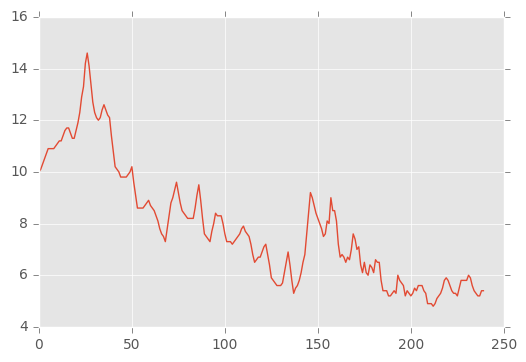

In [173]:
test_stationarity(df_var_t['umpr'])

Results of Dickey-Fuller Test:
Test Statistic                  -2.360835
p-value                          0.153097
#Lags Used                      15.000000
Number of Observations Used    224.000000
Critical Value (5%)             -2.874531
Critical Value (1%)             -3.459885
Critical Value (10%)            -2.573694
dtype: float64


Results of KPSS Test:
Test Statistic            0.669004
p-value                   0.016363
#Lags Used               15.000000
Critical Value (1%)       0.739000
Critical Value (2.5%)     0.574000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
dtype: float64


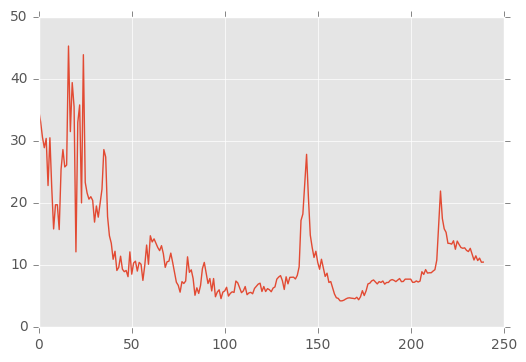

In [174]:
test_stationarity(df_var_t['stir'])

Results of Dickey-Fuller Test:
Test Statistic                -5.799629e+00
p-value                        4.663731e-07
#Lags Used                     2.000000e+00
Number of Observations Used    2.370000e+02
Critical Value (5%)           -2.873814e+00
Critical Value (1%)           -3.458247e+00
Critical Value (10%)          -2.573311e+00
dtype: float64


Results of KPSS Test:
Test Statistic            0.527277
p-value                   0.035523
#Lags Used               15.000000
Critical Value (1%)       0.739000
Critical Value (2.5%)     0.574000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
dtype: float64


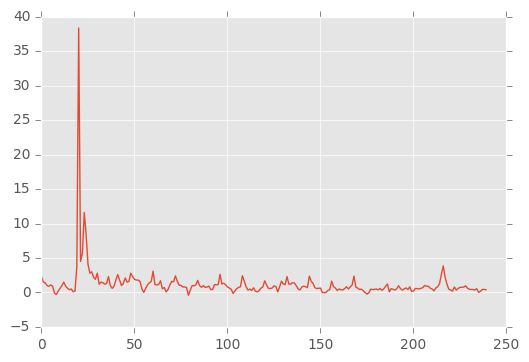

In [175]:
test_stationarity(df_var_t['infr'])

Рвзности

Results of Dickey-Fuller Test:
Test Statistic                  -3.425170
p-value                          0.010130
#Lags Used                      15.000000
Number of Observations Used    223.000000
Critical Value (5%)             -2.874590
Critical Value (1%)             -3.460019
Critical Value (10%)            -2.573725
dtype: float64


Results of KPSS Test:
Test Statistic            0.051855
p-value                   0.100000
#Lags Used               15.000000
Critical Value (1%)       0.739000
Critical Value (2.5%)     0.574000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
dtype: float64


/home/andrey/anaconda3/envs/neural_net/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1260: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


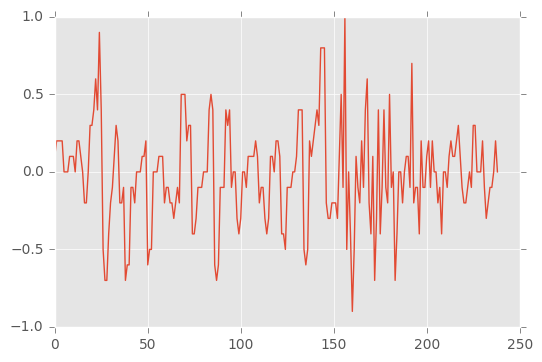

In [176]:
test_stationarity(diff_series(df_var_t['umpr']))

Results of Dickey-Fuller Test:
Test Statistic                  -5.087974
p-value                          0.000015
#Lags Used                      11.000000
Number of Observations Used    227.000000
Critical Value (5%)             -2.874358
Critical Value (1%)             -3.459490
Critical Value (10%)            -2.573602
dtype: float64


Results of KPSS Test:
Test Statistic            0.215061
p-value                   0.100000
#Lags Used               15.000000
Critical Value (1%)       0.739000
Critical Value (2.5%)     0.574000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
dtype: float64


/home/andrey/anaconda3/envs/neural_net/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1260: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


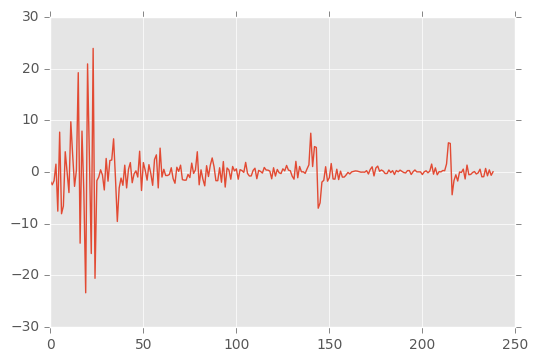

In [177]:
test_stationarity(diff_series(df_var_t['stir']))

Results of Dickey-Fuller Test:
Test Statistic                -1.462021e+01
p-value                        3.895774e-27
#Lags Used                     2.000000e+00
Number of Observations Used    2.360000e+02
Critical Value (5%)           -2.873866e+00
Critical Value (1%)           -3.458366e+00
Critical Value (10%)          -2.573339e+00
dtype: float64


Results of KPSS Test:
Test Statistic            0.031833
p-value                   0.100000
#Lags Used               15.000000
Critical Value (1%)       0.739000
Critical Value (2.5%)     0.574000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
dtype: float64


/home/andrey/anaconda3/envs/neural_net/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1260: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


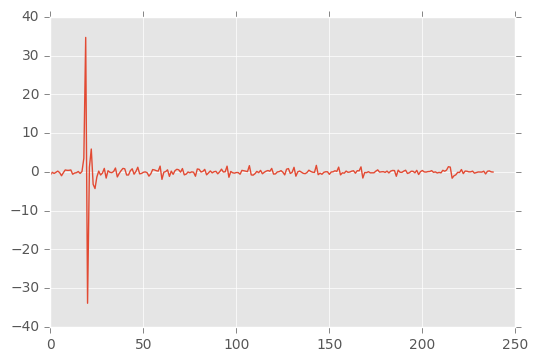

In [178]:
test_stationarity(diff_series(df_var_t['infr']))

In [179]:
df_var_t_diff = diff_series(df_var_t)

## Forecasting

In [184]:
STEPS = 6
LAG = 2

In [185]:
train = df_var_t_diff.iloc[:-STEPS, :]
test = df_var_t_diff.iloc[-STEPS:, :]

train_real = df_var_t.iloc[:-STEPS, :]
test_real = df_var_t.iloc[-STEPS:, :]

### VAR

In [198]:
def var_model(train, steps, lags, years=None, period='m'):
    df = np.array(train)
    years_out=None
    
    b=1
    s=1
    p=steps
    if period=='q':
        p = steps*3
        s=3
        b=3
    
    if years is not None:
        years = pd.to_datetime(years)
        years_out = [pd.to_datetime(years[len(years)-1]) + relativedelta(months=i) for i in range(b, p+1, s)]
    model = VAR(df)
    fitm = model.fit(maxlags=lags)
    var_in = pd.DataFrame(fitm.fittedvalues, 
                          columns=train.columns, 
                          index=years)
    var_out = fitm.forecast(y=df, steps=steps)
    var_out = pd.DataFrame(var_out, 
                           columns=train.columns, 
                           index=years_out)
    return {'in':var_in, 'out':var_out}

In [199]:
var_result = var_model(train, steps=STEPS, lags=LAG, years=train.index[LAG:], period='m')
print(error(var_result['out']['stir'], test['stir']))
print(error(var_result['out']['infr'], test['infr']))
print(error(var_result['out']['umpr'], test['umpr']))

{'mse': 0.49481622115222662, 'rmse': 0.70343174590874602, 'mae': 0.63291012903200905}
{'mse': 0.05538794268955452, 'rmse': 0.23534643122332347, 'mae': 0.1552483422830071}
{'mse': 0.0095986457078878363, 'rmse': 0.097972678374574587, 'mae': 0.064728391596659413}


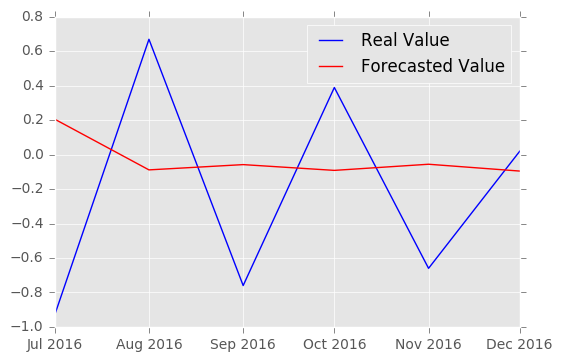

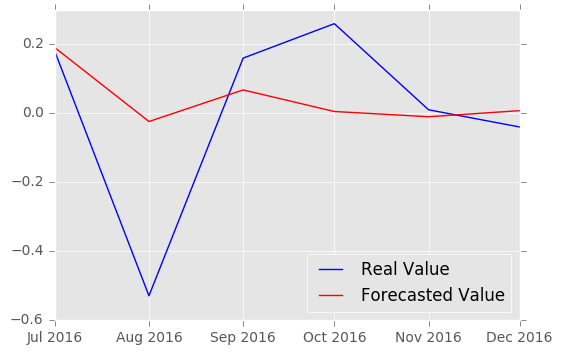

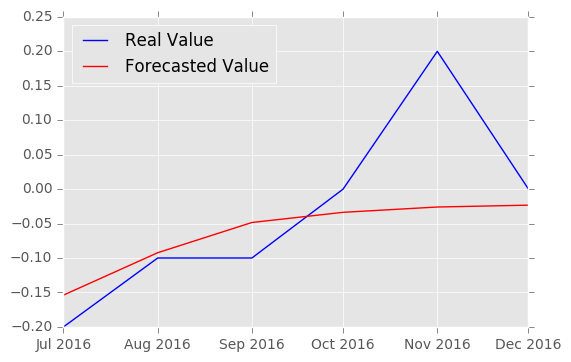

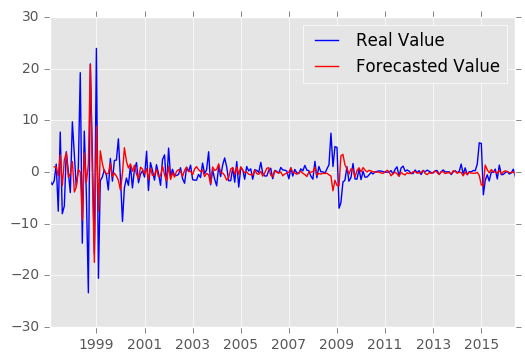

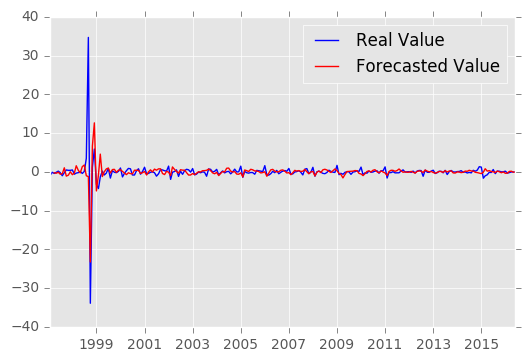

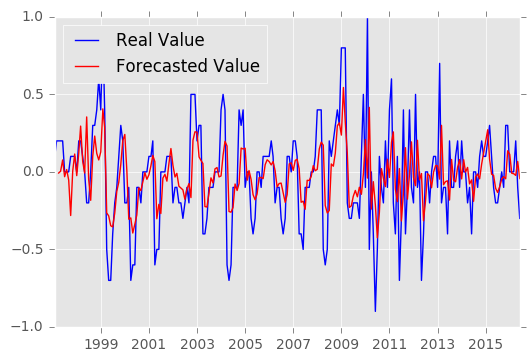

In [200]:
plot_compar(var_result['out']['stir'], test['stir'])
plot_compar(var_result['out']['infr'], test['infr'])
plot_compar(var_result['out']['umpr'], test['umpr'])
plot_compar(var_result['in']['stir'], train['stir'])
plot_compar(var_result['in']['infr'], train['infr'])
plot_compar(var_result['in']['umpr'], train['umpr'])

{'mse': 0.93138576988254529, 'rmse': 0.96508329686226846, 'mae': 0.91384027750562036}
{'mse': 0.089322629215028523, 'rmse': 0.29886891644168773, 'mae': 0.24420609730426288}
{'mse': 0.012770016268948317, 'rmse': 0.1130044966757886, 'mae': 0.10149386773852598}


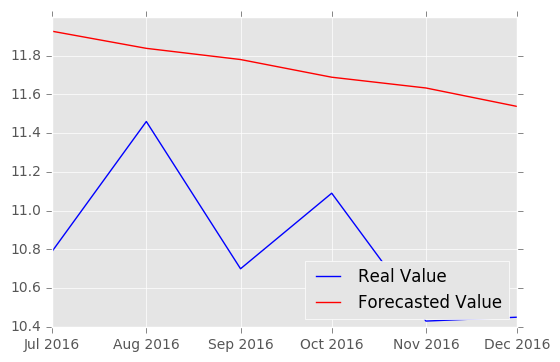

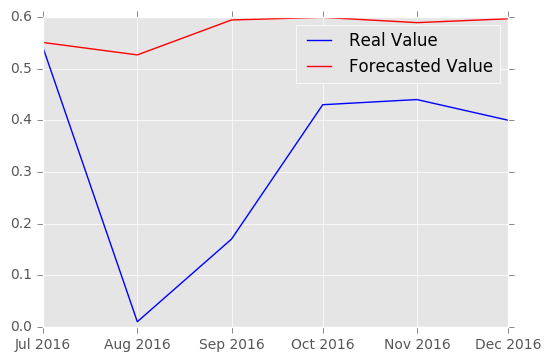

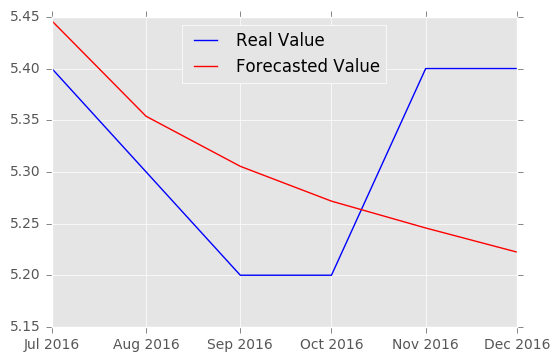

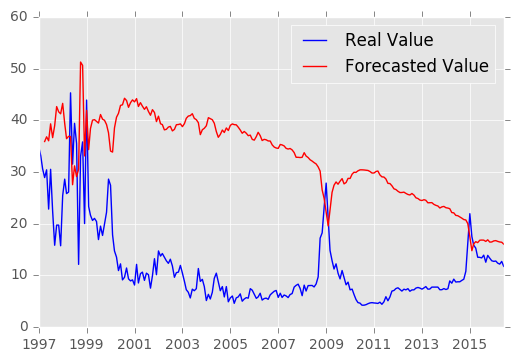

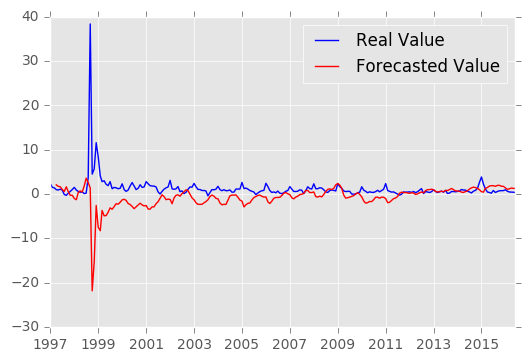

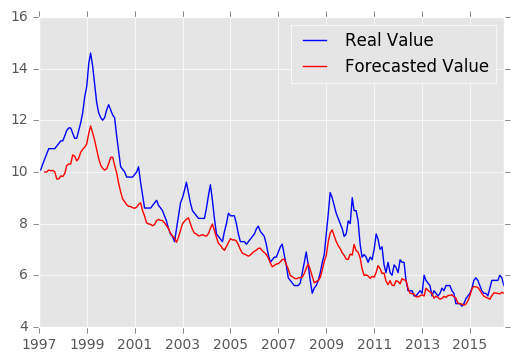

In [201]:
var_undiff_out = undiff(previous_df=train_real, diff_df=var_result['out'])
var_undiff_in = undiff(previous_df=train_real.head(1), diff_df=var_result['in'])
print(error(var_undiff_out['stir'], test_real['stir']))
print(error(var_undiff_out['infr'], test_real['infr']))
print(error(var_undiff_out['umpr'], test_real['umpr']))
plot_compar(var_undiff_out['stir'], test_real['stir'])
plot_compar(var_undiff_out['infr'], test_real['infr'])
plot_compar(var_undiff_out['umpr'], test_real['umpr'])
plot_compar(var_undiff_in['stir'], train_real['stir'])
plot_compar(var_undiff_in['infr'], train_real['infr'])
plot_compar(var_undiff_in['umpr'], train_real['umpr'])

## ANN

In [202]:
df_nn = nn_transform(train, n=LAG)
df_nn_s, m, s = scaler(df_nn)
train_nn_x = df_nn_s.iloc[:, 3:].copy()
train_nn_y = df_nn_s.iloc[:, :3].copy()

In [203]:
def nn_model(x, y, n_feat, lag, steps, model, years=None, epoch=100, period='m'):
    years_out=None
    
    b=1
    s=1
    p=steps
    if period=='q':
        p = steps*3
        s=3
        b=3
    
    if years is not None:
        years = pd.to_datetime(years)
        years_out = [pd.to_datetime(years[len(years)-1]) + relativedelta(months=i) for i in range(b, p+1, s)]
    model.fit(np.array(x), np.array(y),
       nb_epoch=epoch, 
       verbose=2,
       batch_size=1)
    nn_in = pd.DataFrame(model.predict(np.array(x)), 
                         columns=y.columns, 
                         index=years)
    nn_out = nn_predict(model, train, lags=lag, steps=steps)
    if years is not None:
        nn_out.index = years_out
    return {'in':nn_in, 'out':nn_out}

Первый запуск

In [204]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)

In [205]:
nn_result = nn_model(train_nn_x, train_nn_y, 
                     n_feat=3, lag=LAG, steps=STEPS, model=nn, 
                     years=train_nn_y.index, 
                     epoch=500)
nn_result_as = {'in':scaler_back(nn_result['in'], m, s)[train_real.columns.tolist()], 
                'out':scaler_back(nn_result['out'], m, s)[train_real.columns.tolist()]}

Epoch 1/500
0s - loss: 1.1293
Epoch 2/500
0s - loss: 0.9972
Epoch 3/500
0s - loss: 0.9871
Epoch 4/500
0s - loss: 0.9830
Epoch 5/500
0s - loss: 0.9751
Epoch 6/500
0s - loss: 0.9688
Epoch 7/500
0s - loss: 0.9583
Epoch 8/500
0s - loss: 0.9553
Epoch 9/500
0s - loss: 0.9477
Epoch 10/500
0s - loss: 0.9412
Epoch 11/500
0s - loss: 0.9354
Epoch 12/500
0s - loss: 0.9291
Epoch 13/500
0s - loss: 0.9243
Epoch 14/500
0s - loss: 0.9172
Epoch 15/500
0s - loss: 0.9124
Epoch 16/500
0s - loss: 0.9089
Epoch 17/500
0s - loss: 0.9056
Epoch 18/500
0s - loss: 0.9001
Epoch 19/500
0s - loss: 0.8965
Epoch 20/500
0s - loss: 0.8917
Epoch 21/500
0s - loss: 0.8887
Epoch 22/500
0s - loss: 0.8840
Epoch 23/500
0s - loss: 0.8838
Epoch 24/500
0s - loss: 0.8785
Epoch 25/500
0s - loss: 0.8749
Epoch 26/500
0s - loss: 0.8731
Epoch 27/500
0s - loss: 0.8714
Epoch 28/500
0s - loss: 0.8673
Epoch 29/500
0s - loss: 0.8632
Epoch 30/500
0s - loss: 0.8609
Epoch 31/500
0s - loss: 0.8608
Epoch 32/500
0s - loss: 0.8574
Epoch 33/500
0s -

{'mse': 0.97312332629497023, 'rmse': 0.98647013451749777, 'mae': 0.85025542620365913}
{'mse': 0.12084865416675881, 'rmse': 0.34763293021052943, 'mae': 0.29877906260403603}
{'mse': 0.010858484596209134, 'rmse': 0.10420405268610781, 'mae': 0.074366278337649749}


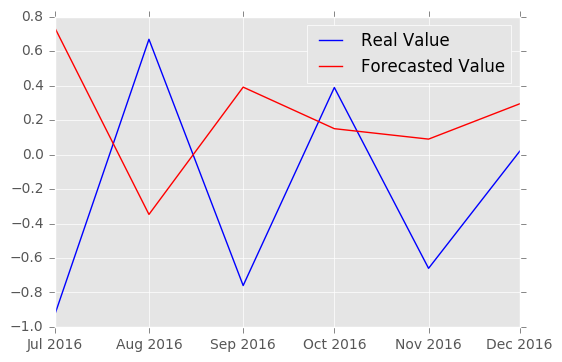

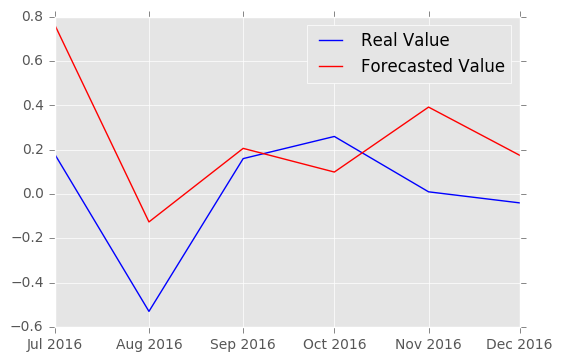

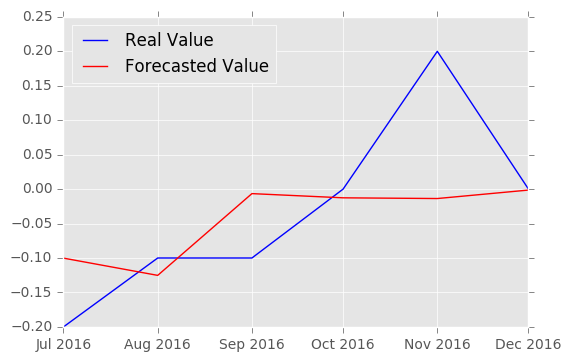

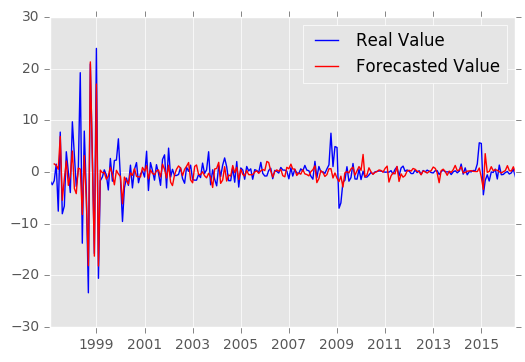

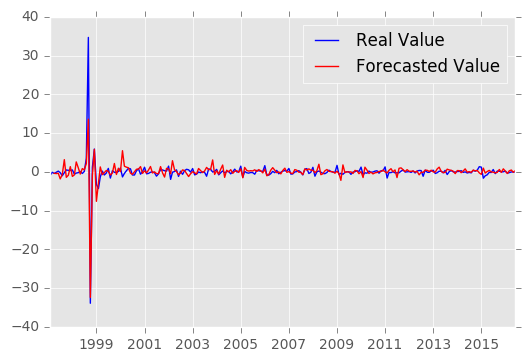

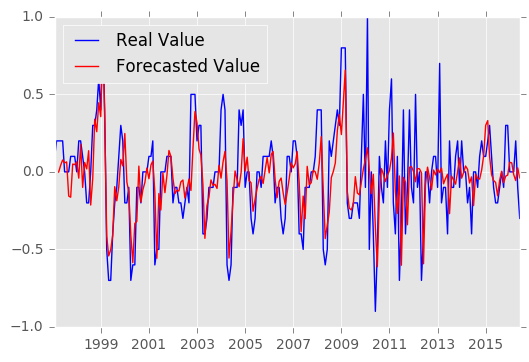

In [206]:
print(error(nn_result_as['out']['stir'], test['stir']))
print(error(nn_result_as['out']['infr'], test['infr']))
print(error(nn_result_as['out']['umpr'], test['umpr']))

plot_compar(nn_result_as['out']['stir'], test['stir'])
plot_compar(nn_result_as['out']['infr'], test['infr'])
plot_compar(nn_result_as['out']['umpr'], test['umpr'])
plot_compar(nn_result_as['in']['stir'], train['stir'])
plot_compar(nn_result_as['in']['infr'], train['infr'])
plot_compar(nn_result_as['in']['umpr'], train['umpr'])

{'mse': 3.493417421531237, 'rmse': 1.8690685973316328, 'mae': 1.7647641051006897}
{'mse': 1.1491296812905285, 'rmse': 1.0719746644816417, 'mae': 1.0347324695191777}
{'mse': 0.012477930602160701, 'rmse': 0.11170465792508699, 'mae': 0.10263046132738148}


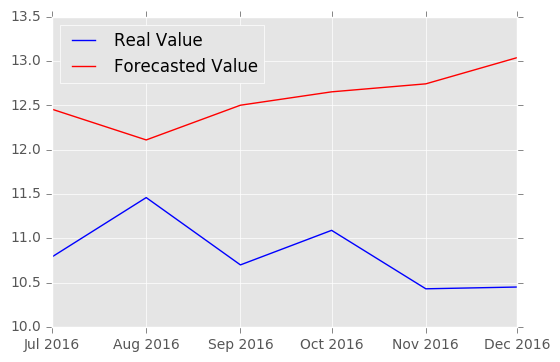

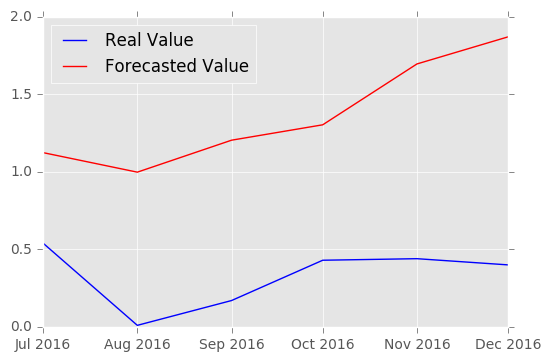

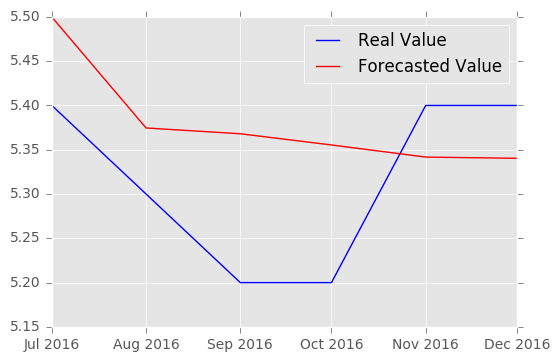

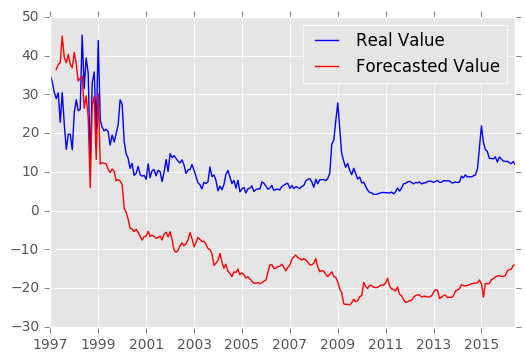

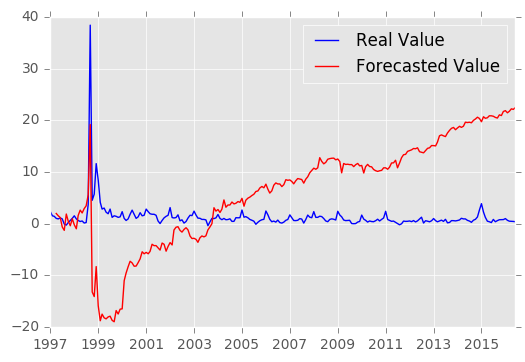

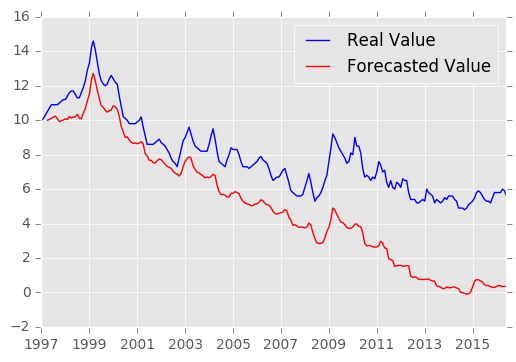

In [207]:
nn_undiff_out = undiff(previous_df=train_real, diff_df=nn_result_as['out'])
nn_undiff_in = undiff(previous_df=train_real.head(1), diff_df=nn_result_as['in'])
print(error(nn_undiff_out['stir'], test_real['stir']))
print(error(nn_undiff_out['infr'], test_real['infr']))
print(error(nn_undiff_out['umpr'], test_real['umpr']))
plot_compar(nn_undiff_out['stir'], test_real['stir'])
plot_compar(nn_undiff_out['infr'], test_real['infr'])
plot_compar(nn_undiff_out['umpr'], test_real['umpr'])
plot_compar(nn_undiff_in['stir'], train_real['stir'])
plot_compar(nn_undiff_in['infr'], train_real['infr'])
plot_compar(nn_undiff_in['umpr'], train_real['umpr'])

Второй запуск

In [208]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
nn_result = nn_model(train_nn_x, train_nn_y, 
                     n_feat=3, lag=LAG, steps=STEPS, model=nn, 
                     years=train_nn_y.index, 
                     epoch=600)
nn_result_as = {'in':scaler_back(nn_result['in'], m, s)[train_real.columns.tolist()], 
                'out':scaler_back(nn_result['out'], m, s)[train_real.columns.tolist()]}

Epoch 1/600
0s - loss: 1.1333
Epoch 2/600
0s - loss: 1.0018
Epoch 3/600
0s - loss: 0.9961
Epoch 4/600
0s - loss: 0.9866
Epoch 5/600
0s - loss: 0.9794
Epoch 6/600
0s - loss: 0.9754
Epoch 7/600
0s - loss: 0.9652
Epoch 8/600
0s - loss: 0.9596
Epoch 9/600
0s - loss: 0.9521
Epoch 10/600
0s - loss: 0.9442
Epoch 11/600
0s - loss: 0.9378
Epoch 12/600
0s - loss: 0.9320
Epoch 13/600
0s - loss: 0.9260
Epoch 14/600
0s - loss: 0.9229
Epoch 15/600
0s - loss: 0.9183
Epoch 16/600
0s - loss: 0.9136
Epoch 17/600
0s - loss: 0.9095
Epoch 18/600
0s - loss: 0.9052
Epoch 19/600
0s - loss: 0.9023
Epoch 20/600
0s - loss: 0.9003
Epoch 21/600
0s - loss: 0.8964
Epoch 22/600
0s - loss: 0.8937
Epoch 23/600
0s - loss: 0.8903
Epoch 24/600
0s - loss: 0.8893
Epoch 25/600
0s - loss: 0.8883
Epoch 26/600
0s - loss: 0.8824
Epoch 27/600
0s - loss: 0.8828
Epoch 28/600
0s - loss: 0.8811
Epoch 29/600
0s - loss: 0.8778
Epoch 30/600
0s - loss: 0.8763
Epoch 31/600
0s - loss: 0.8727
Epoch 32/600
0s - loss: 0.8722
Epoch 33/600
0s -

{'mse': 1.3883463833487344, 'rmse': 1.1782811138895226, 'mae': 0.96331932911033624}
{'mse': 0.28920627012825212, 'rmse': 0.53777901607282164, 'mae': 0.52309282620177167}
{'mse': 0.010262212875437526, 'rmse': 0.10130258079356876, 'mae': 0.078553421333888512}


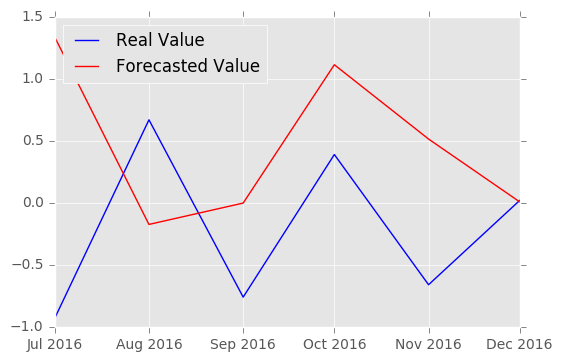

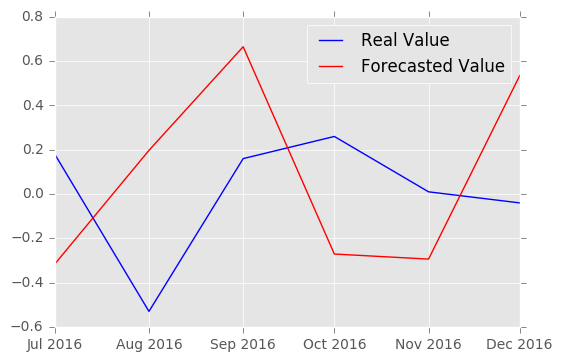

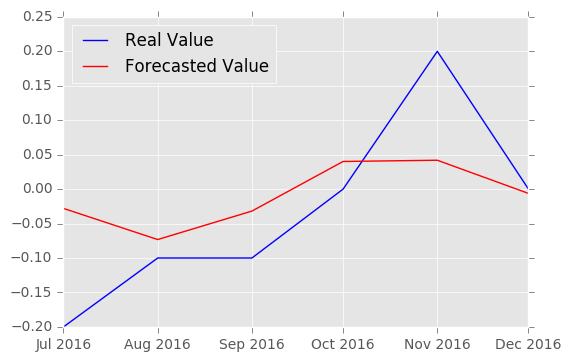

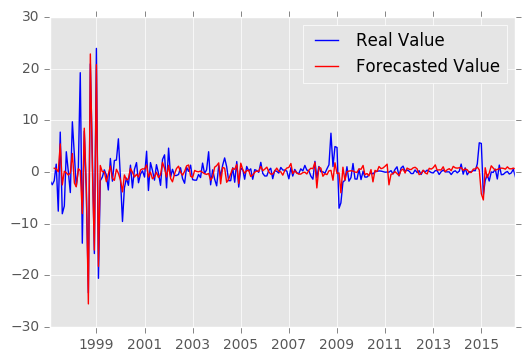

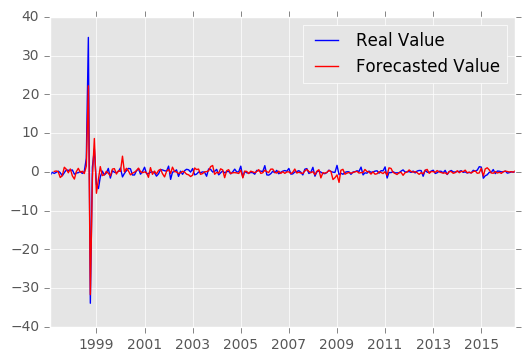

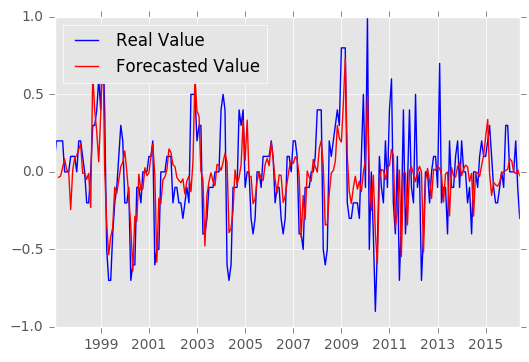

In [209]:
print(error(nn_result_as['out']['stir'], test['stir']))
print(error(nn_result_as['out']['infr'], test['infr']))
print(error(nn_result_as['out']['umpr'], test['umpr']))

plot_compar(nn_result_as['out']['stir'], test['stir'])
plot_compar(nn_result_as['out']['infr'], test['infr'])
plot_compar(nn_result_as['out']['umpr'], test['umpr'])
plot_compar(nn_result_as['in']['stir'], train['stir'])
plot_compar(nn_result_as['in']['infr'], train['infr'])
plot_compar(nn_result_as['in']['umpr'], train['umpr'])

{'mse': 8.9278462835456907, 'rmse': 2.9879501809008948, 'mae': 2.8209392203657173}
{'mse': 0.1865637301471148, 'rmse': 0.43193023759296456, 'mae': 0.37377893854943106}
{'mse': 0.046179185262171941, 'rmse': 0.21489342768491534, 'mae': 0.20602977585401158}


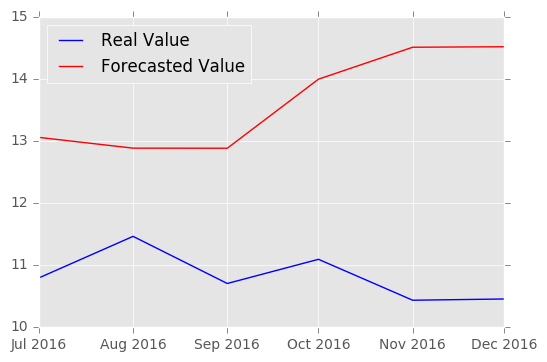

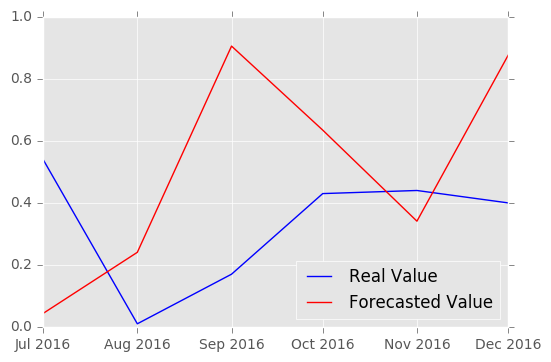

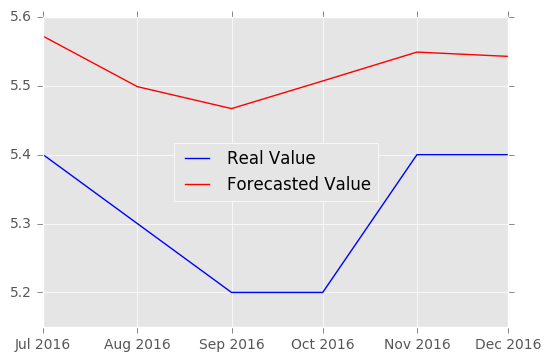

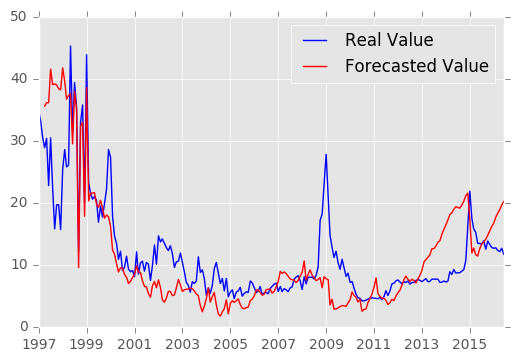

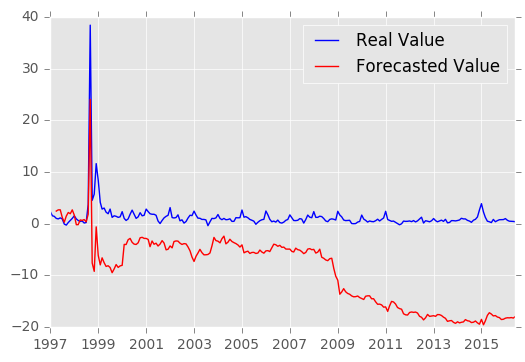

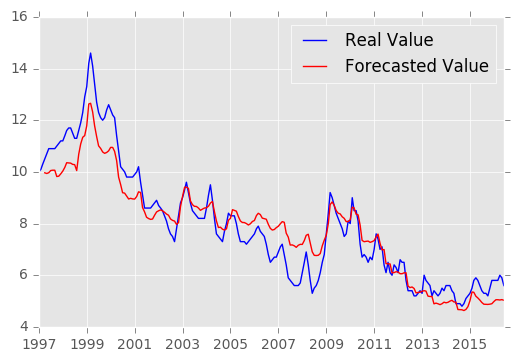

In [210]:
nn_undiff_out = undiff(previous_df=train_real, diff_df=nn_result_as['out'])
nn_undiff_in = undiff(previous_df=train_real.head(1), diff_df=nn_result_as['in'])
print(error(nn_undiff_out['stir'], test_real['stir']))
print(error(nn_undiff_out['infr'], test_real['infr']))
print(error(nn_undiff_out['umpr'], test_real['umpr']))
plot_compar(nn_undiff_out['stir'], test_real['stir'])
plot_compar(nn_undiff_out['infr'], test_real['infr'])
plot_compar(nn_undiff_out['umpr'], test_real['umpr'])
plot_compar(nn_undiff_in['stir'], train_real['stir'])
plot_compar(nn_undiff_in['infr'], train_real['infr'])
plot_compar(nn_undiff_in['umpr'], train_real['umpr'])

С DropOut

In [211]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
nn_result = nn_model(train_nn_x, train_nn_y, 
                     n_feat=3, lag=LAG, steps=STEPS, model=nn, 
                     years=train_nn_y.index, 
                     epoch=600)

Epoch 1/600
0s - loss: 1.0284
Epoch 2/600
0s - loss: 1.0016
Epoch 3/600
0s - loss: 1.0042
Epoch 4/600
0s - loss: 0.9951
Epoch 5/600
0s - loss: 1.0175
Epoch 6/600
0s - loss: 1.0131
Epoch 7/600
0s - loss: 0.9997
Epoch 8/600
0s - loss: 1.0094
Epoch 9/600
0s - loss: 0.9907
Epoch 10/600
0s - loss: 0.9940
Epoch 11/600
0s - loss: 0.9856
Epoch 12/600
0s - loss: 0.9965
Epoch 13/600
0s - loss: 0.9767
Epoch 14/600
0s - loss: 0.9797
Epoch 15/600
0s - loss: 0.9713
Epoch 16/600
0s - loss: 0.9867
Epoch 17/600
0s - loss: 0.9719
Epoch 18/600
0s - loss: 0.9854
Epoch 19/600
0s - loss: 0.9825
Epoch 20/600
0s - loss: 0.9864
Epoch 21/600
0s - loss: 0.9573
Epoch 22/600
0s - loss: 0.9670
Epoch 23/600
0s - loss: 0.9751
Epoch 24/600
0s - loss: 0.9566
Epoch 25/600
0s - loss: 0.9567
Epoch 26/600
0s - loss: 0.9317
Epoch 27/600
0s - loss: 0.9662
Epoch 28/600
0s - loss: 0.9416
Epoch 29/600
0s - loss: 0.9628
Epoch 30/600
0s - loss: 0.9494
Epoch 31/600
0s - loss: 0.9486
Epoch 32/600
0s - loss: 0.9576
Epoch 33/600
0s -

{'mse': 0.51680393541989111, 'rmse': 0.71889076737699942, 'mae': 0.61931016070508493}
{'mse': 0.069381975471212998, 'rmse': 0.26340458513703402, 'mae': 0.1938636644737568}
{'mse': 0.013111614330734739, 'rmse': 0.11450595762114188, 'mae': 0.089662791706181924}


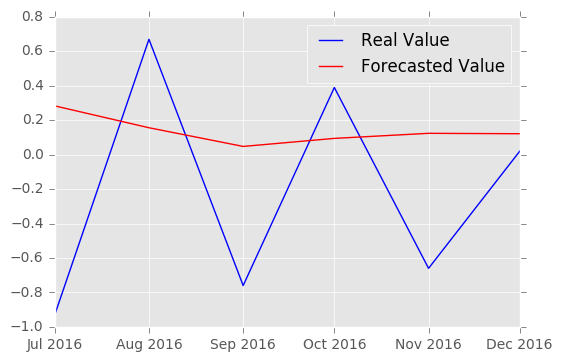

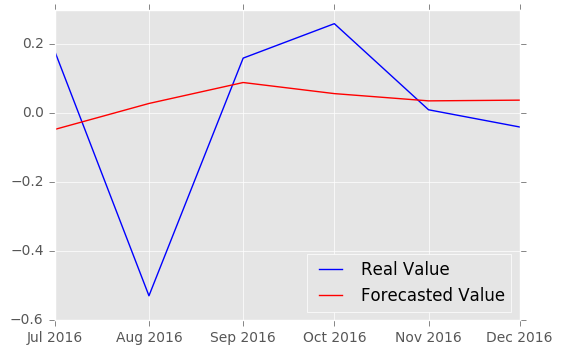

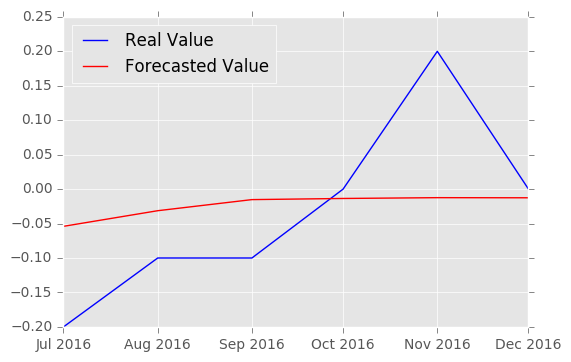

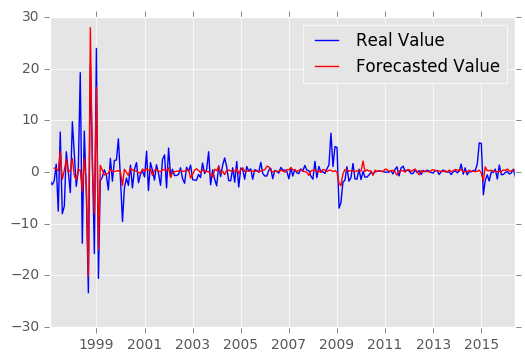

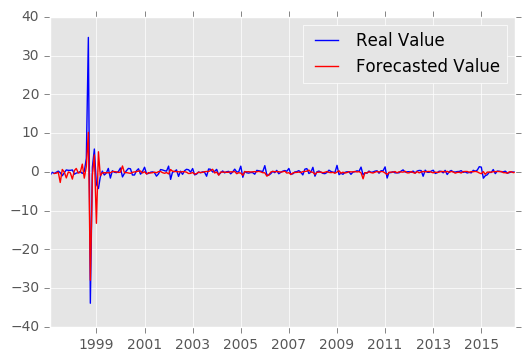

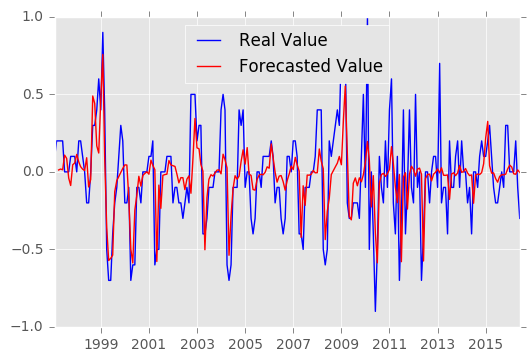

In [212]:
nn_result_as = {'in':scaler_back(nn_result['in'], m, s)[train_real.columns.tolist()], 
                'out':scaler_back(nn_result['out'], m, s)[train_real.columns.tolist()]}
print(error(nn_result_as['out']['stir'], test['stir']))
print(error(nn_result_as['out']['infr'], test['infr']))
print(error(nn_result_as['out']['umpr'], test['umpr']))

plot_compar(nn_result_as['out']['stir'], test['stir'])
plot_compar(nn_result_as['out']['infr'], test['infr'])
plot_compar(nn_result_as['out']['umpr'], test['umpr'])
plot_compar(nn_result_as['in']['stir'], train['stir'])
plot_compar(nn_result_as['in']['infr'], train['infr'])
plot_compar(nn_result_as['in']['umpr'], train['umpr'])

{'mse': 2.3478016839466629, 'rmse': 1.5322537922768091, 'mae': 1.4543375698910035}
{'mse': 0.044202814371739056, 'rmse': 0.21024465361035713, 'mae': 0.18670672723475809}
{'mse': 0.041294390225740864, 'rmse': 0.20321021191303568, 'mae': 0.17999358173010163}


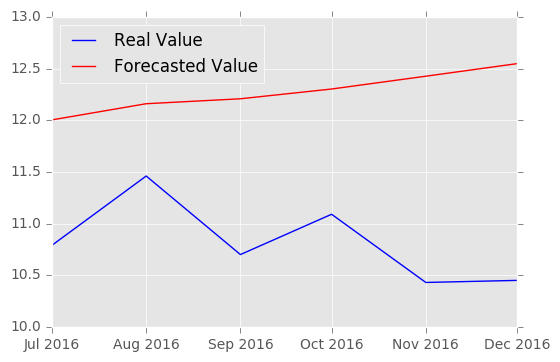

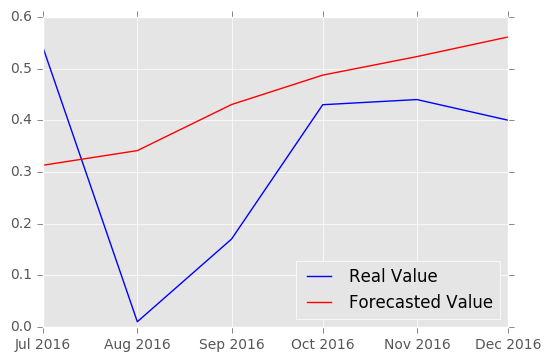

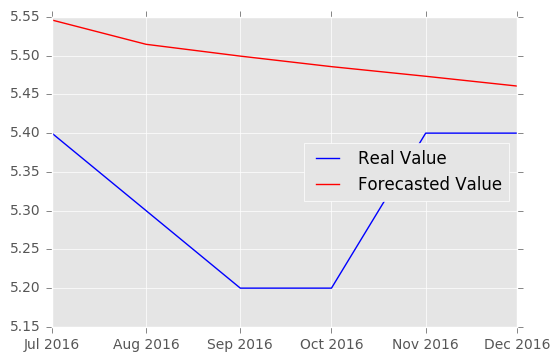

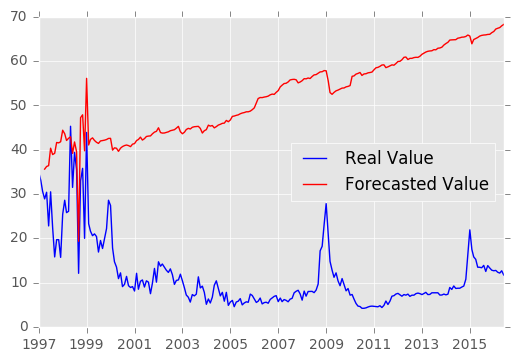

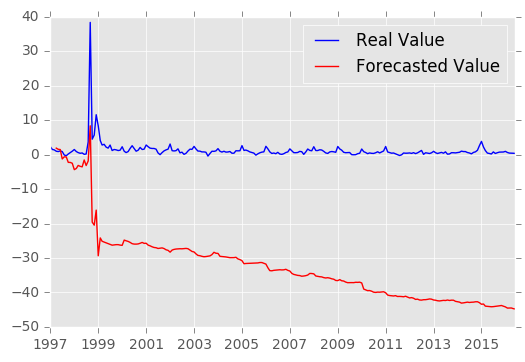

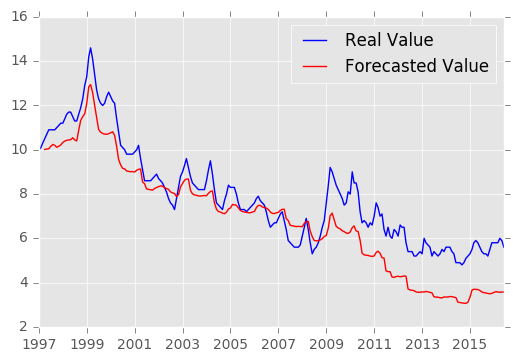

In [213]:
nn_undiff_out = undiff(previous_df=train_real, diff_df=nn_result_as['out'])
nn_undiff_in = undiff(previous_df=train_real.head(1), diff_df=nn_result_as['in'])
print(error(nn_undiff_out['stir'], test_real['stir']))
print(error(nn_undiff_out['infr'], test_real['infr']))
print(error(nn_undiff_out['umpr'], test_real['umpr']))
plot_compar(nn_undiff_out['stir'], test_real['stir'])
plot_compar(nn_undiff_out['infr'], test_real['infr'])
plot_compar(nn_undiff_out['umpr'], test_real['umpr'])
plot_compar(nn_undiff_in['stir'], train_real['stir'])
plot_compar(nn_undiff_in['infr'], train_real['infr'])
plot_compar(nn_undiff_in['umpr'], train_real['umpr'])

На оригинальных данных, а не разницах

In [214]:
df_nn = nn_transform(train_real, n=LAG)
df_nn_s, m, s = scaler(df_nn)
train_nn_x = df_nn_s.iloc[:, 3:].copy()
train_nn_y = df_nn_s.iloc[:, :3].copy()

In [215]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
nn_result = nn_model(train_nn_x, train_nn_y, 
                     n_feat=3, lag=LAG, steps=STEPS, model=nn, 
                     years=train_nn_y.index, 
                     epoch=600)

Epoch 1/600
0s - loss: 1.1141
Epoch 2/600
0s - loss: 0.9437
Epoch 3/600
0s - loss: 0.8600
Epoch 4/600
0s - loss: 0.7690
Epoch 5/600
0s - loss: 0.6831
Epoch 6/600
0s - loss: 0.6122
Epoch 7/600
0s - loss: 0.5631
Epoch 8/600
0s - loss: 0.5314
Epoch 9/600
0s - loss: 0.5115
Epoch 10/600
0s - loss: 0.4974
Epoch 11/600
0s - loss: 0.4849
Epoch 12/600
0s - loss: 0.4766
Epoch 13/600
0s - loss: 0.4693
Epoch 14/600
0s - loss: 0.4613
Epoch 15/600
0s - loss: 0.4532
Epoch 16/600
0s - loss: 0.4450
Epoch 17/600
0s - loss: 0.4354
Epoch 18/600
0s - loss: 0.4270
Epoch 19/600
0s - loss: 0.4190
Epoch 20/600
0s - loss: 0.4095
Epoch 21/600
0s - loss: 0.3999
Epoch 22/600
0s - loss: 0.3926
Epoch 23/600
0s - loss: 0.3867
Epoch 24/600
0s - loss: 0.3797
Epoch 25/600
0s - loss: 0.3751
Epoch 26/600
0s - loss: 0.3715
Epoch 27/600
0s - loss: 0.3687
Epoch 28/600
0s - loss: 0.3646
Epoch 29/600
0s - loss: 0.3634
Epoch 30/600
0s - loss: 0.3608
Epoch 31/600
0s - loss: 0.3590
Epoch 32/600
0s - loss: 0.3571
Epoch 33/600
0s -

{'mse': 26.355970043536654, 'rmse': 5.1338065841572815, 'mae': 5.1204709719503674}
{'mse': 0.23232183290624711, 'rmse': 0.48199775197219241, 'mae': 0.44175010698936323}
{'mse': 2.7870548462386311, 'rmse': 1.6694474673491919, 'mae': 1.6495646081643918}


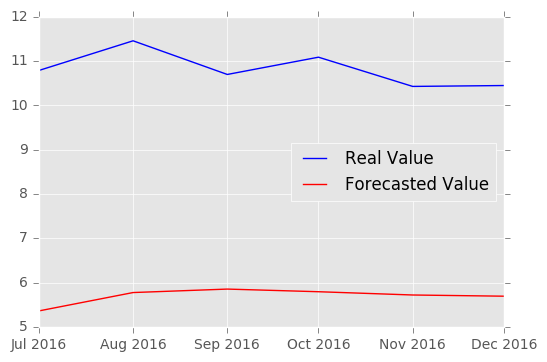

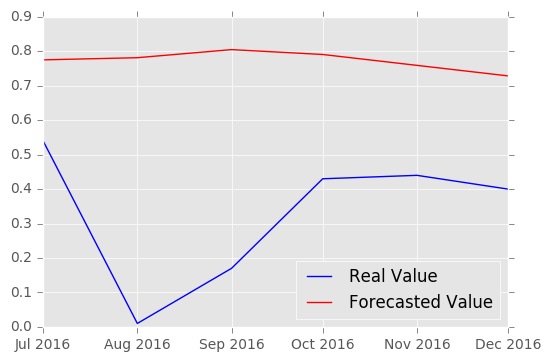

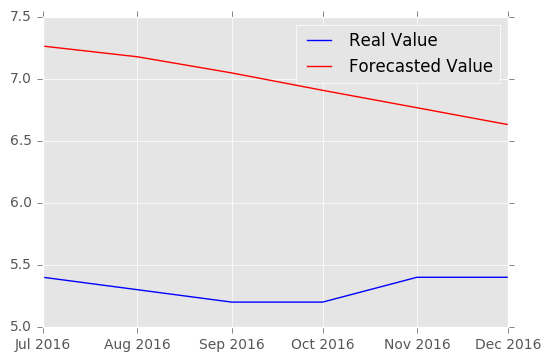

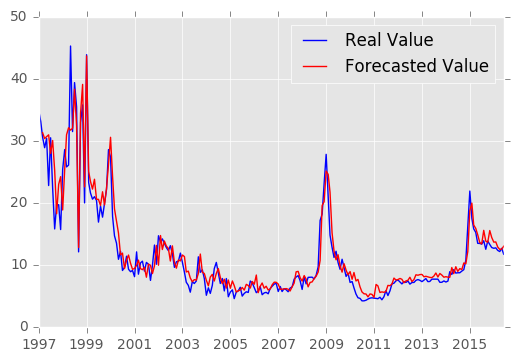

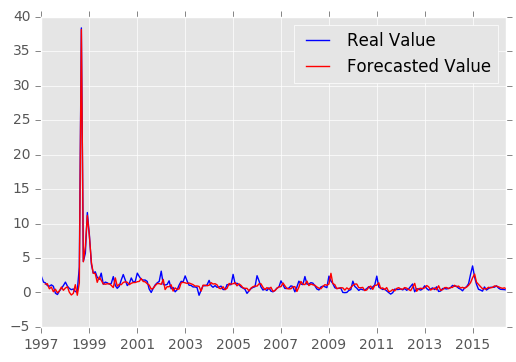

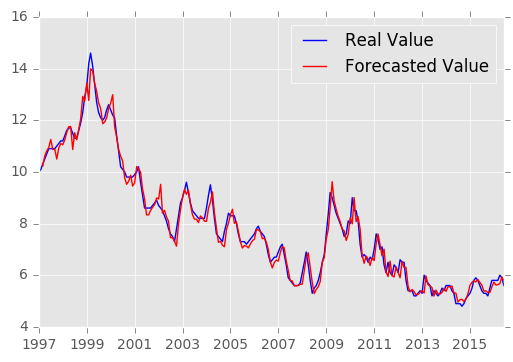

In [216]:
nn_result_as = {'in':scaler_back(nn_result['in'], m, s)[train_real.columns.tolist()], 
                'out':scaler_back(nn_result['out'], m, s)[train_real.columns.tolist()]}
print(error(nn_result_as['out']['stir'], test_real['stir']))
print(error(nn_result_as['out']['infr'], test_real['infr']))
print(error(nn_result_as['out']['umpr'], test_real['umpr']))

plot_compar(nn_result_as['out']['stir'], test_real['stir'])
plot_compar(nn_result_as['out']['infr'], test_real['infr'])
plot_compar(nn_result_as['out']['umpr'], test_real['umpr'])
plot_compar(nn_result_as['in']['stir'], train_real['stir'])
plot_compar(nn_result_as['in']['infr'], train_real['infr'])
plot_compar(nn_result_as['in']['umpr'], train_real['umpr'])

Второй запуск (не на разницах)

In [217]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
nn_result = nn_model(train_nn_x, train_nn_y, 
                     n_feat=3, lag=LAG, steps=STEPS, model=nn, 
                     years=train_nn_y.index, 
                     epoch=600)
nn_result_as = {'in':scaler_back(nn_result['in'], m, s)[train_real.columns.tolist()], 
                'out':scaler_back(nn_result['out'], m, s)[train_real.columns.tolist()]}

Epoch 1/600
0s - loss: 0.9737
Epoch 2/600
0s - loss: 0.8576
Epoch 3/600
0s - loss: 0.7596
Epoch 4/600
0s - loss: 0.6690
Epoch 5/600
0s - loss: 0.5949
Epoch 6/600
0s - loss: 0.5462
Epoch 7/600
0s - loss: 0.5163
Epoch 8/600
0s - loss: 0.5018
Epoch 9/600
0s - loss: 0.4914
Epoch 10/600
0s - loss: 0.4830
Epoch 11/600
0s - loss: 0.4765
Epoch 12/600
0s - loss: 0.4692
Epoch 13/600
0s - loss: 0.4625
Epoch 14/600
0s - loss: 0.4552
Epoch 15/600
0s - loss: 0.4480
Epoch 16/600
0s - loss: 0.4399
Epoch 17/600
0s - loss: 0.4320
Epoch 18/600
0s - loss: 0.4235
Epoch 19/600
0s - loss: 0.4144
Epoch 20/600
0s - loss: 0.4069
Epoch 21/600
0s - loss: 0.3994
Epoch 22/600
0s - loss: 0.3924
Epoch 23/600
0s - loss: 0.3850
Epoch 24/600
0s - loss: 0.3801
Epoch 25/600
0s - loss: 0.3755
Epoch 26/600
0s - loss: 0.3699
Epoch 27/600
0s - loss: 0.3691
Epoch 28/600
0s - loss: 0.3655
Epoch 29/600
0s - loss: 0.3629
Epoch 30/600
0s - loss: 0.3607
Epoch 31/600
0s - loss: 0.3595
Epoch 32/600
0s - loss: 0.3584
Epoch 33/600
0s -

{'mse': 19.62156286523436, 'rmse': 4.4296233322071936, 'mae': 4.3875217820918815}
{'mse': 0.12659966890110197, 'rmse': 0.35580847221658729, 'mae': 0.31813098540297852}
{'mse': 2.7885865191318344, 'rmse': 1.6699061408150562, 'mae': 1.6527826586998611}


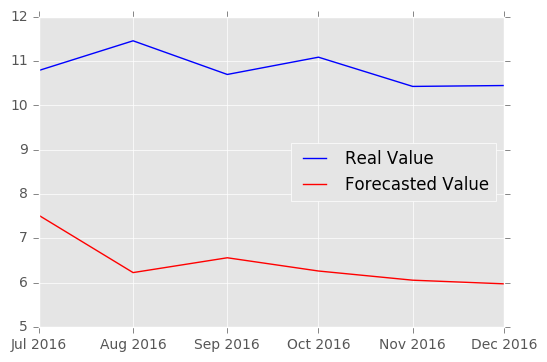

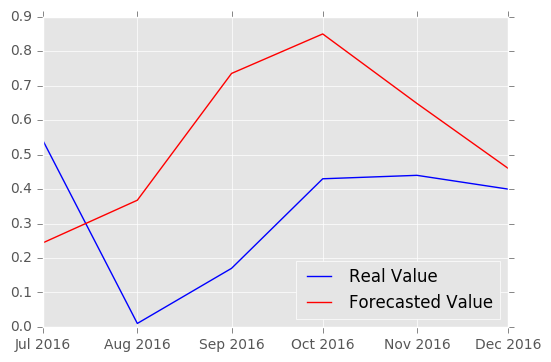

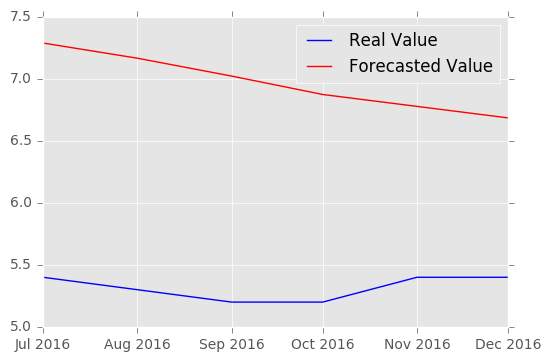

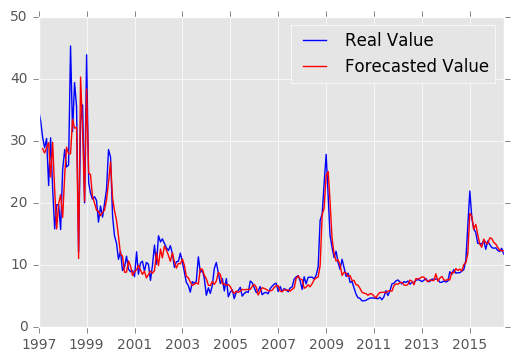

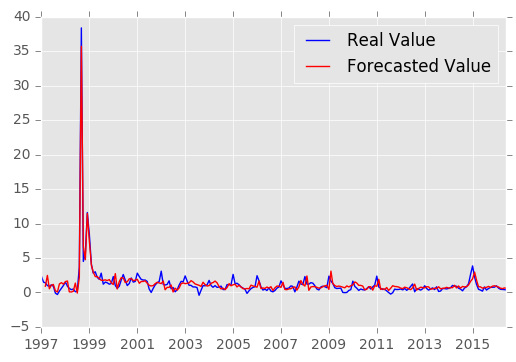

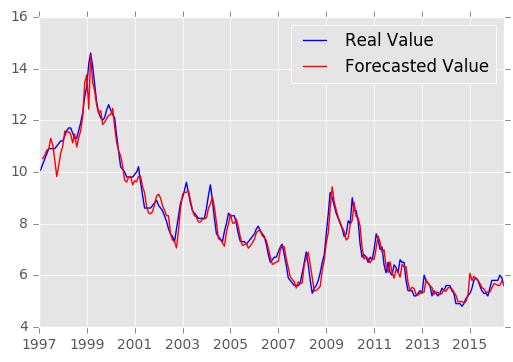

In [218]:
print(error(nn_result_as['out']['stir'], test_real['stir']))
print(error(nn_result_as['out']['infr'], test_real['infr']))
print(error(nn_result_as['out']['umpr'], test_real['umpr']))

plot_compar(nn_result_as['out']['stir'], test_real['stir'])
plot_compar(nn_result_as['out']['infr'], test_real['infr'])
plot_compar(nn_result_as['out']['umpr'], test_real['umpr'])
plot_compar(nn_result_as['in']['stir'], train_real['stir'])
plot_compar(nn_result_as['in']['infr'], train_real['infr'])
plot_compar(nn_result_as['in']['umpr'], train_real['umpr'])

С DropOut

In [219]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
nn_result = nn_model(train_nn_x, train_nn_y, 
                     n_feat=3, lag=LAG, steps=STEPS, model=nn, 
                     years=train_nn_y.index, 
                     epoch=600)
nn_result_as = {'in':scaler_back(nn_result['in'], m, s)[train_real.columns.tolist()], 
                'out':scaler_back(nn_result['out'], m, s)[train_real.columns.tolist()]}

Epoch 1/600
0s - loss: 1.1337
Epoch 2/600
0s - loss: 0.9061
Epoch 3/600
0s - loss: 0.8139
Epoch 4/600
0s - loss: 0.7168
Epoch 5/600
0s - loss: 0.6257
Epoch 6/600
0s - loss: 0.5552
Epoch 7/600
0s - loss: 0.5084
Epoch 8/600
0s - loss: 0.4757
Epoch 9/600
0s - loss: 0.4526
Epoch 10/600
0s - loss: 0.4363
Epoch 11/600
0s - loss: 0.4229
Epoch 12/600
0s - loss: 0.4120
Epoch 13/600
0s - loss: 0.4032
Epoch 14/600
0s - loss: 0.3970
Epoch 15/600
0s - loss: 0.3906
Epoch 16/600
0s - loss: 0.3866
Epoch 17/600
0s - loss: 0.3823
Epoch 18/600
0s - loss: 0.3800
Epoch 19/600
0s - loss: 0.3766
Epoch 20/600
0s - loss: 0.3751
Epoch 21/600
0s - loss: 0.3733
Epoch 22/600
0s - loss: 0.3706
Epoch 23/600
0s - loss: 0.3690
Epoch 24/600
0s - loss: 0.3686
Epoch 25/600
0s - loss: 0.3663
Epoch 26/600
0s - loss: 0.3649
Epoch 27/600
0s - loss: 0.3636
Epoch 28/600
0s - loss: 0.3626
Epoch 29/600
0s - loss: 0.3607
Epoch 30/600
0s - loss: 0.3602
Epoch 31/600
0s - loss: 0.3583
Epoch 32/600
0s - loss: 0.3586
Epoch 33/600
0s -

{'mse': 32.614888738777481, 'rmse': 5.7109446450458163, 'mae': 5.6901624423333708}
{'mse': 0.18118758077622377, 'rmse': 0.42566134517503906, 'mae': 0.40289672878994387}
{'mse': 3.9578193412758886, 'rmse': 1.9894268876427423, 'mae': 1.9839184555108005}


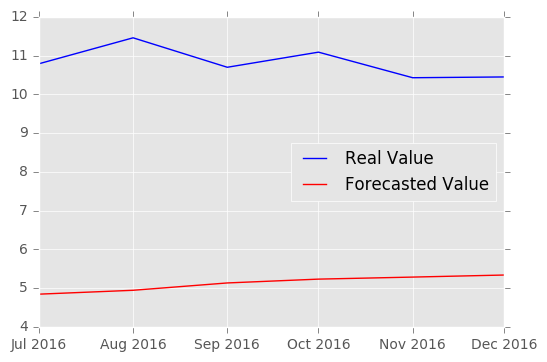

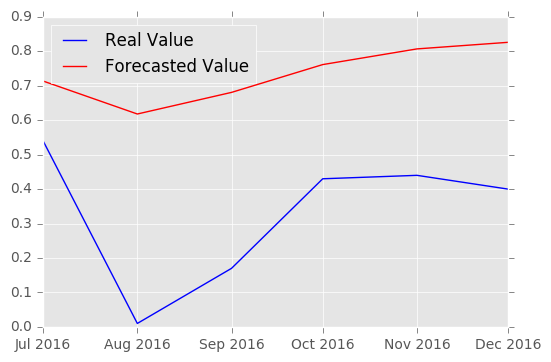

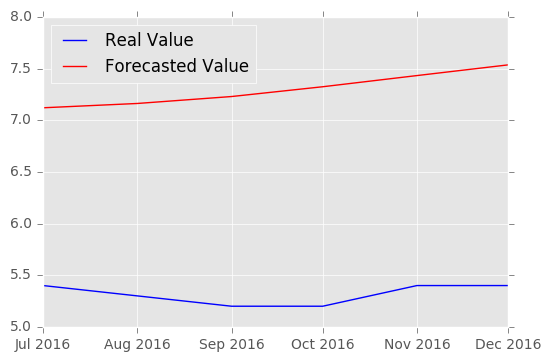

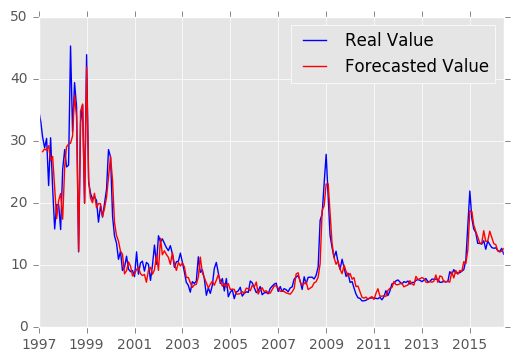

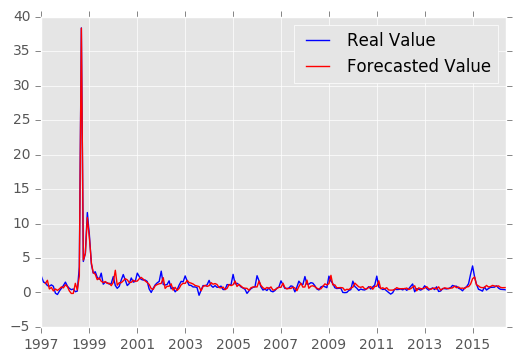

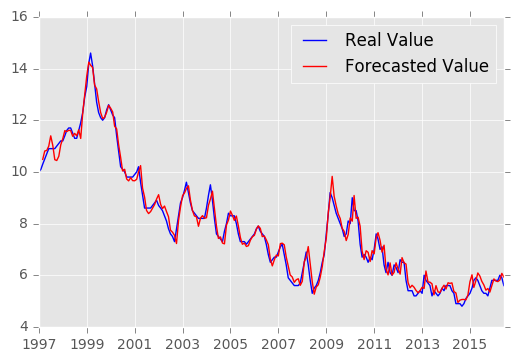

In [220]:
print(error(nn_result_as['out']['stir'], test_real['stir']))
print(error(nn_result_as['out']['infr'], test_real['infr']))
print(error(nn_result_as['out']['umpr'], test_real['umpr']))

plot_compar(nn_result_as['out']['stir'], test_real['stir'])
plot_compar(nn_result_as['out']['infr'], test_real['infr'])
plot_compar(nn_result_as['out']['umpr'], test_real['umpr'])
plot_compar(nn_result_as['in']['stir'], train_real['stir'])
plot_compar(nn_result_as['in']['infr'], train_real['infr'])
plot_compar(nn_result_as['in']['umpr'], train_real['umpr'])

## Hybrid

In [221]:
def hybrid_model(train, lags, steps, model_nn, years=True, epoch=100, period='m'):
    n_feat = len(train.columns)
    model = VAR(np.array(train))
    fitm = model.fit(maxlags=lags)
    var_result = fitm.forecast(y=np.array(train), steps=steps)
    
    resid_df = pd.DataFrame(fitm.resid)
    resid_df.columns = train.columns
    
    df_nn = nn_transform(resid_df, n=lags)
    ###
    df_nn_s, m, s = scaler(df_nn)
    ###
    train_nn_x = df_nn_s.iloc[:, n_feat:].copy()
    train_nn_y = df_nn_s.iloc[:, :n_feat].copy()
    model_nn.fit(np.array(train_nn_x), np.array(train_nn_y),
           nb_epoch=epoch, 
           verbose=2,
           batch_size=1)
    nn_result = nn_predict(model_nn, resid_df, lags=lags, steps=steps)
    ###
    nn_result_as = scaler_back(nn_result, m, s)[train.columns.tolist()]
    ###
    hybrid_result = pd.DataFrame(var_result + nn_result_as.as_matrix())
    hybrid_result.columns = train.columns
    
    b=1
    s=1
    p=steps
    if period=='q':
        p = steps*3
        s=3
        b=3
    
    if years == True:
        ind = [datetime.strptime(str(train.tail(1).index.tolist()[0])[:7], '%Y-%m') + relativedelta(months=i) \
               for i in range(b, p+1, s)]
        hybrid_result.index = ind
    return hybrid_result

In [222]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)

In [223]:
hybrid_result = hybrid_model(train, lags=LAG, steps=STEPS, model_nn=nn, years=True, epoch=200, period='m')

Epoch 1/200
1s - loss: 1.1176
Epoch 2/200
0s - loss: 1.0131
Epoch 3/200
0s - loss: 1.0032
Epoch 4/200
0s - loss: 1.0027
Epoch 5/200
0s - loss: 1.0007
Epoch 6/200
0s - loss: 0.9999
Epoch 7/200
0s - loss: 0.9998
Epoch 8/200
0s - loss: 0.9977
Epoch 9/200
0s - loss: 0.9966
Epoch 10/200
0s - loss: 0.9933
Epoch 11/200
0s - loss: 0.9940
Epoch 12/200
0s - loss: 0.9929
Epoch 13/200
0s - loss: 0.9922
Epoch 14/200
0s - loss: 0.9893
Epoch 15/200
0s - loss: 0.9910
Epoch 16/200
0s - loss: 0.9883
Epoch 17/200
0s - loss: 0.9854
Epoch 18/200
1s - loss: 0.9869
Epoch 19/200
0s - loss: 0.9851
Epoch 20/200
0s - loss: 0.9822
Epoch 21/200
0s - loss: 0.9816
Epoch 22/200
0s - loss: 0.9815
Epoch 23/200
0s - loss: 0.9797
Epoch 24/200
1s - loss: 0.9791
Epoch 25/200
0s - loss: 0.9779
Epoch 26/200
0s - loss: 0.9759
Epoch 27/200
0s - loss: 0.9741
Epoch 28/200
0s - loss: 0.9733
Epoch 29/200
0s - loss: 0.9728
Epoch 30/200
0s - loss: 0.9703
Epoch 31/200
0s - loss: 0.9703
Epoch 32/200
0s - loss: 0.9682
Epoch 33/200
0s -

{'mse': 0.74493347073342953, 'rmse': 0.86309528485181142, 'mae': 0.72554731227272706}
{'mse': 0.13285586179492329, 'rmse': 0.36449398046459325, 'mae': 0.33785614181116452}
{'mse': 0.01107664172868828, 'rmse': 0.10524562569859272, 'mae': 0.073133483896427848}


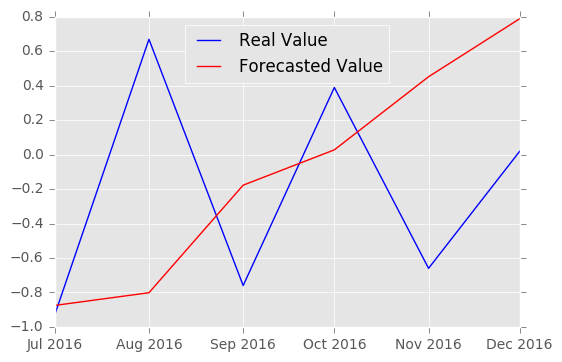

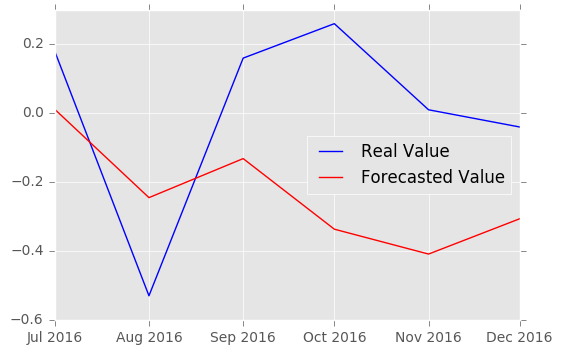

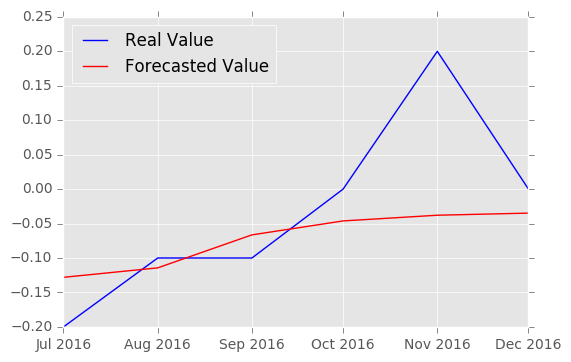

In [224]:
print(error(hybrid_result['stir'], test['stir']))
print(error(hybrid_result['infr'], test['infr']))
print(error(hybrid_result['umpr'], test['umpr']))
plot_compar(hybrid_result['stir'], test['stir'])
plot_compar(hybrid_result['infr'], test['infr'])
plot_compar(hybrid_result['umpr'], test['umpr'])

{'mse': 0.76921463535204992, 'rmse': 0.87704882153278674, 'mae': 0.71194179980275296}
{'mse': 0.70178607964719142, 'rmse': 0.83772673327714176, 'mae': 0.64675601641396663}
{'mse': 0.017985644785545731, 'rmse': 0.13411056925367862, 'mae': 0.11440860931046777}


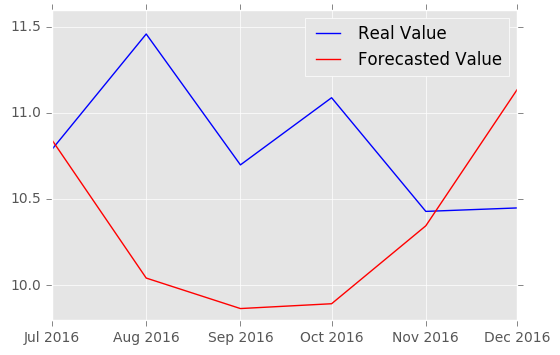

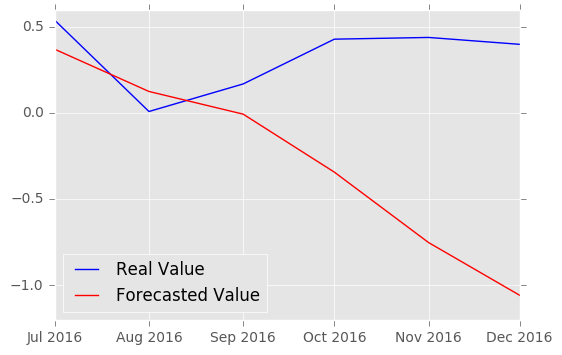

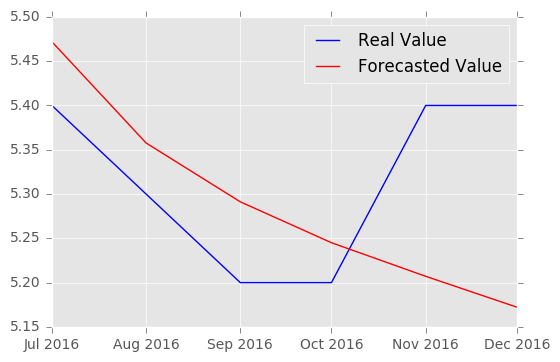

In [225]:
hybrid_undiff_out = undiff(previous_df=train_real, diff_df=hybrid_result)
print(error(hybrid_undiff_out['stir'], test_real['stir']))
print(error(hybrid_undiff_out['infr'], test_real['infr']))
print(error(hybrid_undiff_out['umpr'], test_real['umpr']))
plot_compar(hybrid_undiff_out['stir'], test_real['stir'])
plot_compar(hybrid_undiff_out['infr'], test_real['infr'])
plot_compar(hybrid_undiff_out['umpr'], test_real['umpr'])

Второй запуск

In [226]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
hybrid_result = hybrid_model(train, lags=LAG, steps=STEPS, model_nn=nn, years=True, epoch=200, period='m')

Epoch 1/200
1s - loss: 1.0473
Epoch 2/200
1s - loss: 0.9984
Epoch 3/200
1s - loss: 0.9975
Epoch 4/200
1s - loss: 0.9987
Epoch 5/200
1s - loss: 0.9979
Epoch 6/200
0s - loss: 0.9948
Epoch 7/200
1s - loss: 0.9931
Epoch 8/200
1s - loss: 0.9934
Epoch 9/200
0s - loss: 0.9923
Epoch 10/200
1s - loss: 0.9918
Epoch 11/200
0s - loss: 0.9896
Epoch 12/200
0s - loss: 0.9883
Epoch 13/200
0s - loss: 0.9874
Epoch 14/200
0s - loss: 0.9863
Epoch 15/200
0s - loss: 0.9855
Epoch 16/200
0s - loss: 0.9839
Epoch 17/200
0s - loss: 0.9832
Epoch 18/200
0s - loss: 0.9826
Epoch 19/200
0s - loss: 0.9797
Epoch 20/200
0s - loss: 0.9781
Epoch 21/200
0s - loss: 0.9777
Epoch 22/200
0s - loss: 0.9771
Epoch 23/200
0s - loss: 0.9749
Epoch 24/200
0s - loss: 0.9726
Epoch 25/200
0s - loss: 0.9718
Epoch 26/200
0s - loss: 0.9717
Epoch 27/200
0s - loss: 0.9710
Epoch 28/200
0s - loss: 0.9693
Epoch 29/200
0s - loss: 0.9689
Epoch 30/200
0s - loss: 0.9656
Epoch 31/200
0s - loss: 0.9642
Epoch 32/200
0s - loss: 0.9630
Epoch 33/200
0s -

{'mse': 2.3199299346948643, 'rmse': 1.5231316209359138, 'mae': 1.3443041423457993}
{'mse': 0.089679085063482156, 'rmse': 0.29946466413165035, 'mae': 0.28483236106597748}
{'mse': 0.011818641716432024, 'rmse': 0.10871357650464833, 'mae': 0.076789899938684889}


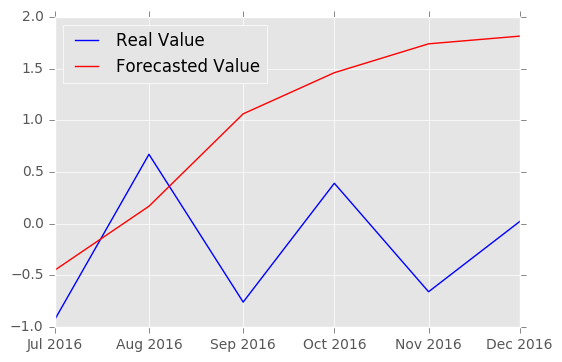

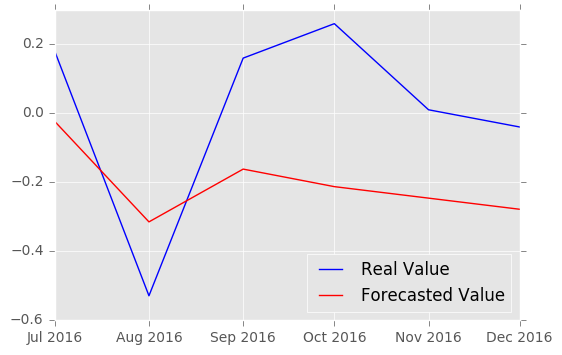

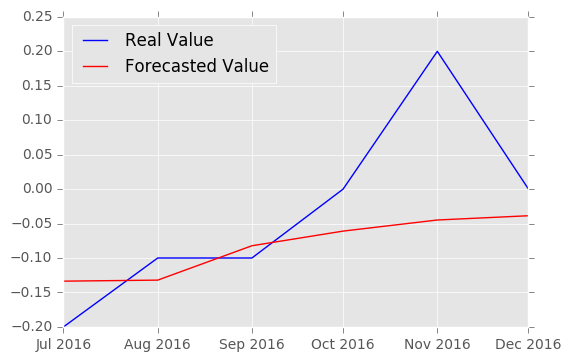

In [227]:
print(error(hybrid_result['stir'], test['stir']))
print(error(hybrid_result['infr'], test['infr']))
print(error(hybrid_result['umpr'], test['umpr']))
plot_compar(hybrid_result['stir'], test['stir'])
plot_compar(hybrid_result['infr'], test['infr'])
plot_compar(hybrid_result['umpr'], test['umpr'])

{'mse': 14.880267715950396, 'rmse': 3.8574950053046595, 'mae': 2.9159558921904547}
{'mse': 0.57934678899345016, 'rmse': 0.76114833573584728, 'mae': 0.60524303638503829}
{'mse': 0.02637701423007649, 'rmse': 0.16241001887222503, 'mae': 0.11796286056632654}


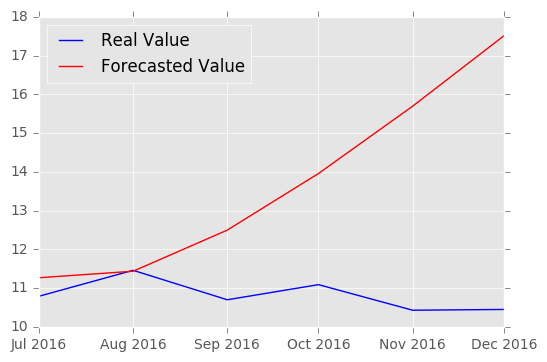

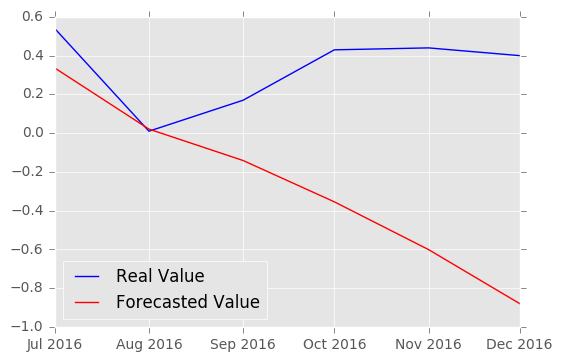

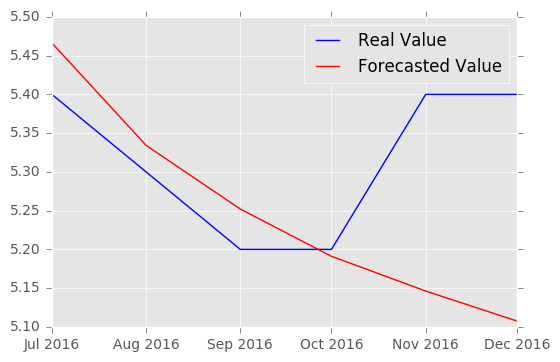

In [228]:
hybrid_undiff_out = undiff(previous_df=train_real, diff_df=hybrid_result)
print(error(hybrid_undiff_out['stir'], test_real['stir']))
print(error(hybrid_undiff_out['infr'], test_real['infr']))
print(error(hybrid_undiff_out['umpr'], test_real['umpr']))
plot_compar(hybrid_undiff_out['stir'], test_real['stir'])
plot_compar(hybrid_undiff_out['infr'], test_real['infr'])
plot_compar(hybrid_undiff_out['umpr'], test_real['umpr'])

С DropOut

In [229]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
hybrid_result = hybrid_model(train, lags=LAG, steps=STEPS, model_nn=nn, years=True, epoch=200, period='m')

Epoch 1/200
1s - loss: 1.0509
Epoch 2/200
0s - loss: 1.0085
Epoch 3/200
0s - loss: 1.0148
Epoch 4/200
0s - loss: 1.0061
Epoch 5/200
0s - loss: 1.0001
Epoch 6/200
0s - loss: 1.0228
Epoch 7/200
0s - loss: 1.0058
Epoch 8/200
0s - loss: 1.0218
Epoch 9/200
0s - loss: 1.0046
Epoch 10/200
0s - loss: 1.0048
Epoch 11/200
0s - loss: 0.9893
Epoch 12/200
0s - loss: 0.9960
Epoch 13/200
0s - loss: 1.0010
Epoch 14/200
0s - loss: 0.9941
Epoch 15/200
0s - loss: 1.0005
Epoch 16/200
0s - loss: 1.0068
Epoch 17/200
0s - loss: 0.9952
Epoch 18/200
0s - loss: 0.9940
Epoch 19/200
0s - loss: 1.0008
Epoch 20/200
0s - loss: 0.9956
Epoch 21/200
0s - loss: 0.9960
Epoch 22/200
0s - loss: 0.9899
Epoch 23/200
0s - loss: 0.9958
Epoch 24/200
0s - loss: 0.9992
Epoch 25/200
0s - loss: 0.9955
Epoch 26/200
0s - loss: 0.9828
Epoch 27/200
0s - loss: 0.9951
Epoch 28/200
0s - loss: 0.9904
Epoch 29/200
0s - loss: 0.9896
Epoch 30/200
0s - loss: 1.0046
Epoch 31/200
0s - loss: 1.0008
Epoch 32/200
0s - loss: 0.9970
Epoch 33/200
0s -

{'mse': 0.35581974510639447, 'rmse': 0.59650628253723736, 'mae': 0.55807907159614467}
{'mse': 0.1087435344849285, 'rmse': 0.32976284582246146, 'mae': 0.22707942292636443}
{'mse': 0.010307454333302291, 'rmse': 0.10152563387294014, 'mae': 0.068584392427179924}


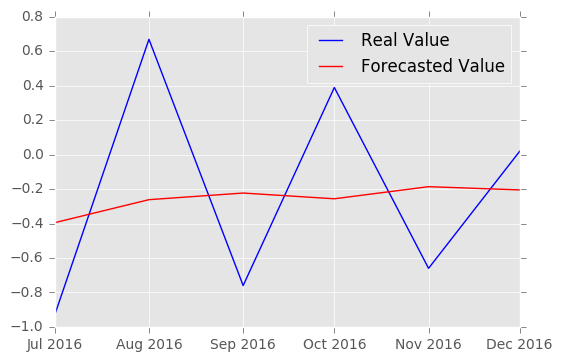

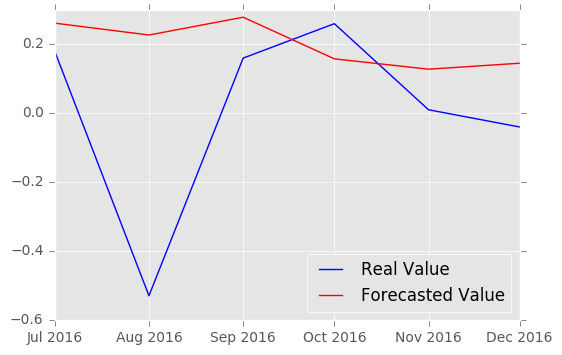

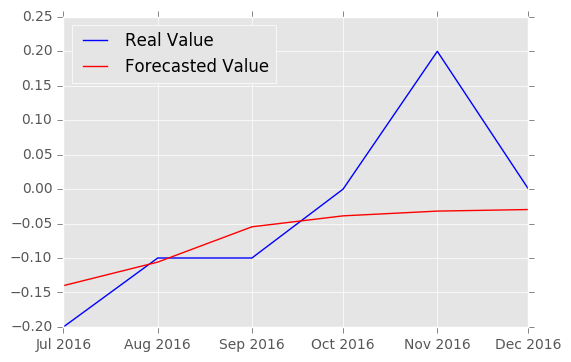

In [230]:
print(error(hybrid_result['stir'], test['stir']))
print(error(hybrid_result['infr'], test['infr']))
print(error(hybrid_result['umpr'], test['umpr']))
plot_compar(hybrid_result['stir'], test['stir'])
plot_compar(hybrid_result['infr'], test['infr'])
plot_compar(hybrid_result['umpr'], test['umpr'])

{'mse': 0.13076737370363115, 'rmse': 0.36161771762958622, 'mae': 0.31066190300357821}
{'mse': 0.77436200669619926, 'rmse': 0.8799784126307868, 'mae': 0.81066893174364629}
{'mse': 0.014981920388531633, 'rmse': 0.12240065518015675, 'mae': 0.10769041851373166}


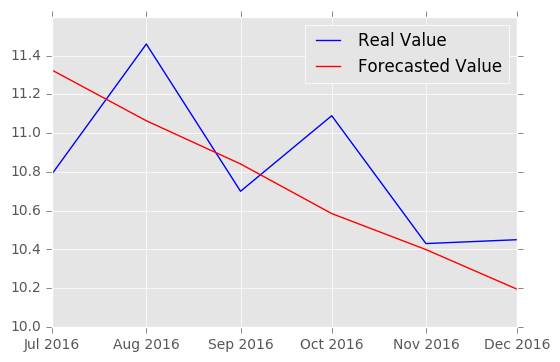

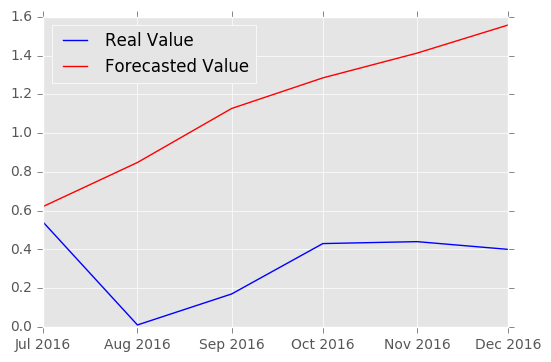

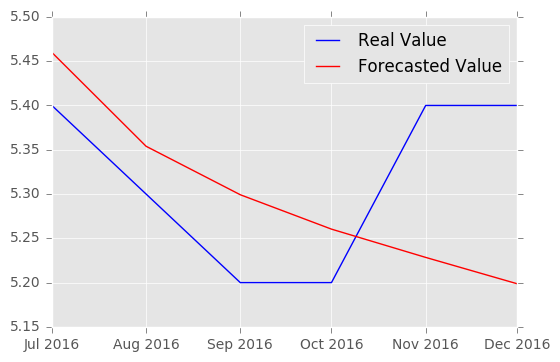

In [231]:
hybrid_undiff_out = undiff(previous_df=train_real, diff_df=hybrid_result)
print(error(hybrid_undiff_out['stir'], test_real['stir']))
print(error(hybrid_undiff_out['infr'], test_real['infr']))
print(error(hybrid_undiff_out['umpr'], test_real['umpr']))
plot_compar(hybrid_undiff_out['stir'], test_real['stir'])
plot_compar(hybrid_undiff_out['infr'], test_real['infr'])
plot_compar(hybrid_undiff_out['umpr'], test_real['umpr'])

### Hybrid_full

In [232]:
#def hybrid_model(train, lags, steps, model_nn, years=True, epoch=100, period='m'):
# lags = LAG
# steps=STEPS
# model_nn=nn
# years=True
# epoch=200
# period='q'

def hybrid_model_undiff(train, train_real, lags, steps, model_nn, years=True, epoch=100, period='m'):
    n_feat = len(train.columns)
    model = VAR(np.array(train))
    fitm = model.fit(maxlags=lags)
    var_result = fitm.forecast(y=np.array(train), steps=steps)
    var_in = undiff(previous_df=train_real.head(1), diff_df=pd.DataFrame(fitm.fittedvalues))
    var_out = undiff(previous_df=train_real, diff_df=pd.DataFrame(var_result))
    resid_df = pd.DataFrame(train_real.iloc[lags+1:, :].as_matrix() - var_in.as_matrix())
    resid_df.columns = train.columns

    df_nn = nn_transform(resid_df, n=lags)
    ###
    df_nn_s, m, s = scaler(df_nn)
    ###
    train_nn_x = df_nn_s.iloc[:, n_feat:].copy()
    train_nn_y = df_nn_s.iloc[:, :n_feat].copy()
    model_nn.fit(np.array(train_nn_x), np.array(train_nn_y),
           nb_epoch=epoch, 
           verbose=2,
           batch_size=1)
    nn_result = nn_predict(model_nn, resid_df, lags=lags, steps=steps)
    ###
    nn_result_as = scaler_back(nn_result, m, s)[train.columns.tolist()]
    ###
    hybrid_result = pd.DataFrame(var_out.as_matrix() + nn_result_as.as_matrix())
    hybrid_result.columns = train.columns

    b=1
    s=1
    p=steps
    if period=='q':
        p = steps*3
        s=3
        b=3

    if years == True:
        ind = [datetime.strptime(str(train.tail(1).index.tolist()[0])[:7], '%Y-%m') + relativedelta(months=i) \
               for i in range(b, p+1, s)]
        hybrid_result.index = ind
    return hybrid_result

Первый запуск

In [233]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
hybrid_result_undiff = hybrid_model_undiff(train, train_real, lags=LAG, steps=STEPS, 
                                    model_nn=nn, years=True, epoch=500, period='m')

Epoch 1/500
0s - loss: 1.5030
Epoch 2/500
0s - loss: 1.0276
Epoch 3/500
0s - loss: 0.9304
Epoch 4/500
0s - loss: 0.8660
Epoch 5/500
0s - loss: 0.7941
Epoch 6/500
0s - loss: 0.7122
Epoch 7/500
0s - loss: 0.6303
Epoch 8/500
0s - loss: 0.5567
Epoch 9/500
0s - loss: 0.4997
Epoch 10/500
0s - loss: 0.4601
Epoch 11/500
0s - loss: 0.4355
Epoch 12/500
0s - loss: 0.4183
Epoch 13/500
0s - loss: 0.4046
Epoch 14/500
0s - loss: 0.3966
Epoch 15/500
0s - loss: 0.3892
Epoch 16/500
0s - loss: 0.3819
Epoch 17/500
0s - loss: 0.3763
Epoch 18/500
0s - loss: 0.3702
Epoch 19/500
0s - loss: 0.3649
Epoch 20/500
0s - loss: 0.3591
Epoch 21/500
0s - loss: 0.3547
Epoch 22/500
0s - loss: 0.3494
Epoch 23/500
0s - loss: 0.3444
Epoch 24/500
0s - loss: 0.3406
Epoch 25/500
0s - loss: 0.3362
Epoch 26/500
0s - loss: 0.3320
Epoch 27/500
0s - loss: 0.3266
Epoch 28/500
0s - loss: 0.3234
Epoch 29/500
0s - loss: 0.3200
Epoch 30/500
0s - loss: 0.3166
Epoch 31/500
0s - loss: 0.3128
Epoch 32/500
0s - loss: 0.3078
Epoch 33/500
0s -

{'mse': 504.97541931619281, 'rmse': 22.471658134552349, 'mae': 21.922100082770175}
{'mse': 3.5240244924385773, 'rmse': 1.877238528381137, 'mae': 1.3362451008364069}
{'mse': 0.44633188232963111, 'rmse': 0.66808074536662942, 'mae': 0.57101934593941905}


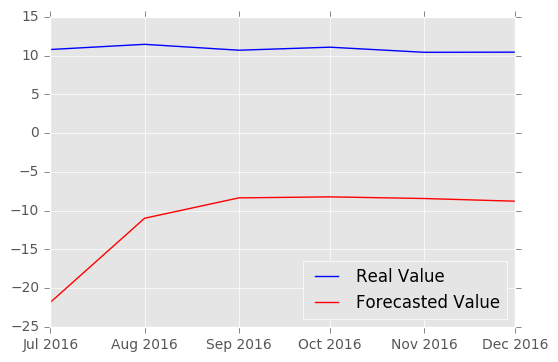

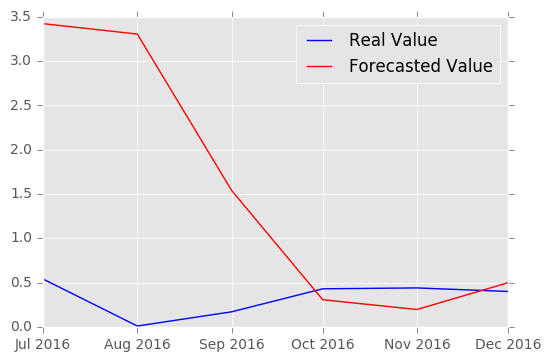

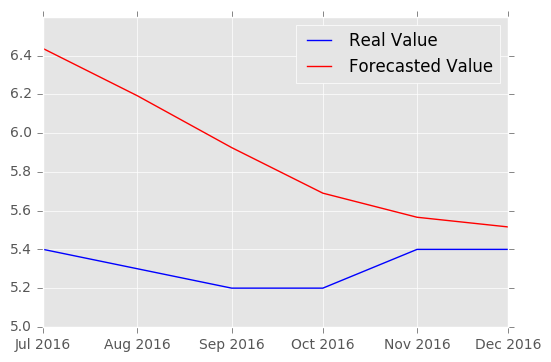

In [234]:
print(error(hybrid_result_undiff['stir'], test_real['stir']))
print(error(hybrid_result_undiff['infr'], test_real['infr']))
print(error(hybrid_result_undiff['umpr'], test_real['umpr']))
plot_compar(hybrid_result_undiff['stir'], test_real['stir'])
plot_compar(hybrid_result_undiff['infr'], test_real['infr'])
plot_compar(hybrid_result_undiff['umpr'], test_real['umpr'])

Второй запуск

In [235]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
hybrid_result_undiff = hybrid_model_undiff(train, train_real, lags=LAG, steps=STEPS, 
                                    model_nn=nn, years=True, epoch=500, period='m')

Epoch 1/500
0s - loss: 1.1417
Epoch 2/500
0s - loss: 0.8957
Epoch 3/500
0s - loss: 0.8072
Epoch 4/500
0s - loss: 0.7448
Epoch 5/500
0s - loss: 0.6980
Epoch 6/500
0s - loss: 0.6603
Epoch 7/500
0s - loss: 0.6277
Epoch 8/500
0s - loss: 0.5956
Epoch 9/500
0s - loss: 0.5625
Epoch 10/500
0s - loss: 0.5266
Epoch 11/500
0s - loss: 0.4911
Epoch 12/500
0s - loss: 0.4574
Epoch 13/500
0s - loss: 0.4304
Epoch 14/500
0s - loss: 0.4091
Epoch 15/500
0s - loss: 0.3935
Epoch 16/500
0s - loss: 0.3821
Epoch 17/500
0s - loss: 0.3731
Epoch 18/500
0s - loss: 0.3648
Epoch 19/500
0s - loss: 0.3597
Epoch 20/500
0s - loss: 0.3542
Epoch 21/500
0s - loss: 0.3486
Epoch 22/500
0s - loss: 0.3430
Epoch 23/500
0s - loss: 0.3375
Epoch 24/500
0s - loss: 0.3329
Epoch 25/500
0s - loss: 0.3283
Epoch 26/500
0s - loss: 0.3244
Epoch 27/500
0s - loss: 0.3205
Epoch 28/500
0s - loss: 0.3162
Epoch 29/500
0s - loss: 0.3127
Epoch 30/500
0s - loss: 0.3081
Epoch 31/500
0s - loss: 0.3042
Epoch 32/500
0s - loss: 0.3016
Epoch 33/500
0s -

{'mse': 696.37888281042058, 'rmse': 26.388991697494252, 'mae': 26.196125239744664}
{'mse': 3.2758145187891246, 'rmse': 1.8099211360689516, 'mae': 1.4866560916636677}
{'mse': 0.16631958388445872, 'rmse': 0.40782298106465104, 'mae': 0.27471994860596843}


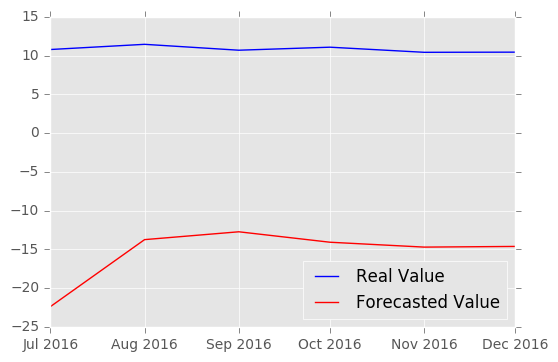

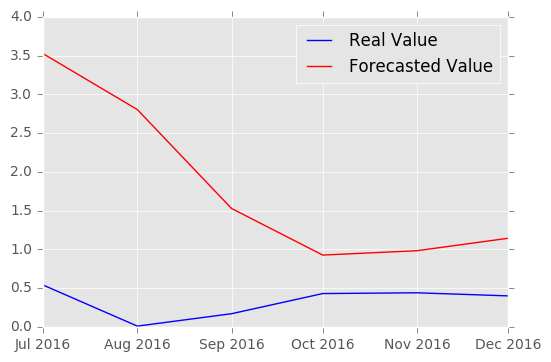

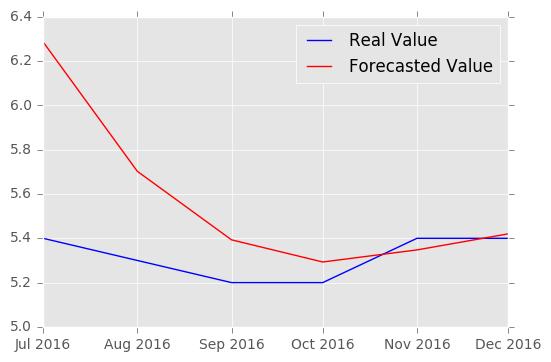

In [236]:
print(error(hybrid_result_undiff['stir'], test_real['stir']))
print(error(hybrid_result_undiff['infr'], test_real['infr']))
print(error(hybrid_result_undiff['umpr'], test_real['umpr']))
plot_compar(hybrid_result_undiff['stir'], test_real['stir'])
plot_compar(hybrid_result_undiff['infr'], test_real['infr'])
plot_compar(hybrid_result_undiff['umpr'], test_real['umpr'])

С DropOut

In [237]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
hybrid_result_undiff = hybrid_model_undiff(train, train_real, lags=LAG, steps=STEPS, 
                                    model_nn=nn, years=True, epoch=500, period='m')

Epoch 1/500
0s - loss: 1.0388
Epoch 2/500
0s - loss: 1.0020
Epoch 3/500
0s - loss: 0.9919
Epoch 4/500
0s - loss: 0.9882
Epoch 5/500
0s - loss: 0.9816
Epoch 6/500
0s - loss: 0.9999
Epoch 7/500
0s - loss: 0.9662
Epoch 8/500
0s - loss: 0.9598
Epoch 9/500
0s - loss: 0.9367
Epoch 10/500
0s - loss: 0.9421
Epoch 11/500
0s - loss: 0.9361
Epoch 12/500
0s - loss: 0.8908
Epoch 13/500
0s - loss: 0.8910
Epoch 14/500
0s - loss: 0.8875
Epoch 15/500
0s - loss: 0.8500
Epoch 16/500
0s - loss: 0.8323
Epoch 17/500
0s - loss: 0.8503
Epoch 18/500
0s - loss: 0.8347
Epoch 19/500
0s - loss: 0.8123
Epoch 20/500
0s - loss: 0.8253
Epoch 21/500
0s - loss: 0.8149
Epoch 22/500
0s - loss: 0.7937
Epoch 23/500
0s - loss: 0.7499
Epoch 24/500
0s - loss: 0.7761
Epoch 25/500
0s - loss: 0.7732
Epoch 26/500
0s - loss: 0.7771
Epoch 27/500
0s - loss: 0.7304
Epoch 28/500
0s - loss: 0.7548
Epoch 29/500
0s - loss: 0.7447
Epoch 30/500
0s - loss: 0.7241
Epoch 31/500
0s - loss: 0.7380
Epoch 32/500
0s - loss: 0.7471
Epoch 33/500
0s -

{'mse': 773.25371463587044, 'rmse': 27.80743991517145, 'mae': 27.787765157237416}
{'mse': 6.986616489988613, 'rmse': 2.6432208553181122, 'mae': 2.6280843282123834}
{'mse': 0.43479543611143789, 'rmse': 0.65939020019366223, 'mae': 0.64825827456393414}


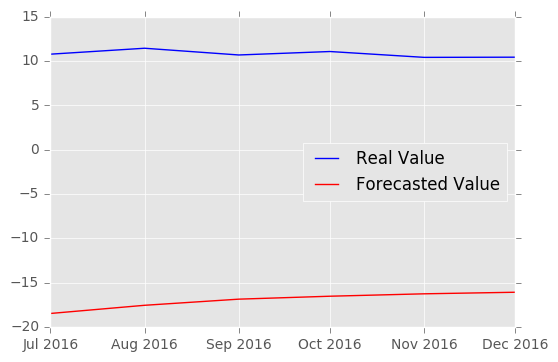

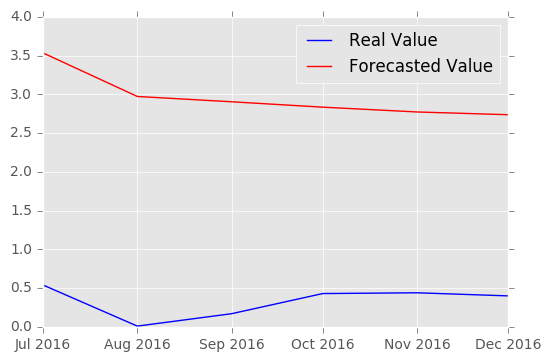

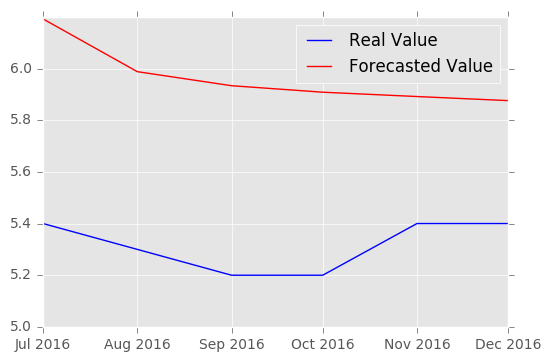

In [238]:
print(error(hybrid_result_undiff['stir'], test_real['stir']))
print(error(hybrid_result_undiff['infr'], test_real['infr']))
print(error(hybrid_result_undiff['umpr'], test_real['umpr']))
plot_compar(hybrid_result_undiff['stir'], test_real['stir'])
plot_compar(hybrid_result_undiff['infr'], test_real['infr'])
plot_compar(hybrid_result_undiff['umpr'], test_real['umpr'])